In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *

from iterate import mycharray,interval_permute,mybin,weighted_sum,plot3dplot,binarize


In [2]:
data_path = Path('/data/cresswellclayec/DCA_ER/furano_periwal_prot')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER/furano_periwal_prot' # Set DCA_ER directory

data_dir = "%s/protein_data/" % DCA_ER_dir

In [3]:
colors = [(.71,.32,.8),(1.0,.65,0.),(.55,0.,0.),(0,.8,.8),(0.,.55,.55),\
                  (1.0,.1,.58),(0.,0.,.80),(0.4,0.4,0.4)]

In [4]:
all_seqs = []
with open('protein_data/all_seqs.fa', 'rU') as f:
    seq_iter = SeqIO.parse(f,'fasta')
    for seq in seq_iter:
        all_seqs.append(seq)

lp_msas = []
lp_fa_prefix = 'protein_data/'
lp_names = ['L1Pa1', 'L1Pa2', 'L1Pa3', 'L1Pa4', 'L1Pa5', 'L1Pa6', 'L1Pa7' ]
total_len = 0
lp_files = ['cls1.1.fasta','cls1.2.fasta','cls123.3.fasta','cls1ab234.4.fasta','cls123.5.fasta','cls1abc234.6.fasta','cls123.7.fasta']
lp_ids = []
for i,filename in enumerate(lp_files):
    lp_msas.append([])
    lp_ids.append([])
    print('Loading MSA for ',lp_names[i])
    with open(lp_fa_prefix+filename, 'rU') as f:
        seq_iter = SeqIO.parse(f,'fasta')
        for seq in seq_iter:
#             print(seq)
            lp_msas[-1].append(seq.seq) 
            lp_ids[-1].append(seq.id)
    f.close()
#     print(lp_msas[-1][0][:5])
    print(len(lp_msas[-1]))
    total_len += len(lp_msas[-1])
print('number of all individual LPa MSA sequences: ',total_len)
print('number of all aligned sequences: ',len(all_seqs))

non_evo_seqs = []
non_evo_ids = []
filename = '151_cc_all_peps_fnl_ed.1.fa'
print('Loading MSA for ',filename)
with open(filename, 'rU') as f:
    seq_iter = SeqIO.parse(f,'fasta')
    for seq in seq_iter:
#             print(seq)

        non_evo_seqs.append(seq.seq) 
        non_evo_ids.append(seq.id)
f.close()

non_evo_seqs = np.array([np.array(list(str(record))) for record in non_evo_seqs])


Loading MSA for  L1Pa1
295
Loading MSA for  L1Pa2
499
Loading MSA for  L1Pa3
1000
Loading MSA for  L1Pa4
1104
Loading MSA for  L1Pa5
741
Loading MSA for  L1Pa6
599
Loading MSA for  L1Pa7
103
number of all individual LPa MSA sequences:  4341
number of all aligned sequences:  4341
Loading MSA for  151_cc_all_peps_fnl_ed.1.fa


In [5]:
family_ref = []
family_indx = []
for ii,ids in enumerate(lp_names):
    family_indx.append([])
for i,seq in enumerate(all_seqs):
    found = False
    for j,ids in enumerate(lp_ids):
        if seq.id in ids:
            family_ref.append(j)
            family_indx[j].append(i)
            found=True
            break
    if not found:
        print('could not categorize sequence!!')
        
family_ref = np.array(family_ref)
print('all familys contained?: ',np.unique(family_ref))
print('\nnumber of ids attributed to each family:')
for i in range(7):
    family_seqs = family_ref==i
    print(family_seqs.sum(axis=0))
    print(len(family_indx[i]))
family_colors = [colors[i] for i in family_ref]

all familys contained?:  [0 1 2 3 4 5 6]

number of ids attributed to each family:
295
295
499
499
1000
1000
1104
1104
741
741
599
599
103
103


In [6]:
s0 = np.array([seq.seq for seq in all_seqs])
print(s0.shape)

full_s0 = np.concatenate((s0,non_evo_seqs), axis=0)


onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
print('s0: ',s0.shape,'\n',s0)
onehot_encoder.fit(full_s0)
s = onehot_encoder.transform(s0)
non_evo_s = onehot_encoder.transform(non_evo_seqs)
print('s: ',s.shape,'\n',s)

(4341, 101)
s0:  (4341, 101) 
 [['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ...
 ['L' 'Y' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['F' 'C' '-' ... 'W' 'D' 'Y']]
s:  (4341, 1329) 
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
    
from sklearn.decomposition import PCA
pca_dim=3

pca = PCA(n_components = pca_dim)
s_pca = pca.fit_transform(s)
non_evo_s_pca = pca.transform(non_evo_s)
full_s = np.concatenate((s, non_evo_s))
full_s_pca = pca.transform(full_s)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


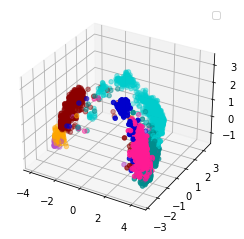

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], c=family_colors)
plt.legend()
plt.show()


## Generate w_ER

In [9]:

# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(full_s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var


Number of residue positions: 101
Number of sequences: 4341
Number of different amino acids at each position [16 11  7 11 16 14 18 15 12 13 17 15 12 14 15 13 13 17 16 11 18 16 15 11
 17 12 12 11 12 14 16 16 12 13 22 13 16 18 13  9 13 12 10 15 13 15  2 13
 15  3 15 13 17 16 13 15 16 13  2 16 18 12 18 13 12 16 16 11 13 12 13 12
 13 14 12 12  9 14  2 12 16 13 14 11 12 12 14 13 12 14 14  7 14 13 13 10
 13 10 14 14 13]
Total number of variables 1329


In [10]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER                                                                      
s_centered = s - s.mean(axis=0)      

s_train = s 
# Define wight matrix with variable for each possible amino acid at each sequence position               
w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
h0 = np.zeros(mx.sum())             

# Expectation Reflection                                                                                 
#=========================================================================================#
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                                                                                        


w_file = "%s/w.npy" % (data_dir)        
# if os.path.exists(w_file) and not create_new:                                                          
if 0:                                                                                                    
    w_ER = np.load(w_file)                                                                               
else:                                                                                                    
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var))                                                                      
                                                                                                         
    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    
        
        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]
        
        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      
        
    # make w symmetric                                                                                   
    w_ER = (w_ER + w_ER.T)/2.                                                                            
    
    np.save(w_file, w_ER)


/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 115.13457990100142


In [11]:
from scipy.spatial import distance

def E(i1i2, s, w):
    E = 0
    s_len = len(i1i2)
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s[j1:j2]
            E += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E

print(E(i1i2, s[1,:], w_ER))


def energy_diff(i1i2, s1, s2, w):
    e_diff = 0.
    s_len = len(i1i2)

    E1 = E(i1i2, s1, w)
    E2 = E(i1i2, s2, w)
    #print(E1)
    #print(E2)
    
    e_diff1 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s1[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s2[j1:j2]
            e_diff1 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    
    e_diff2 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s2[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s1[j1:j2]
            e_diff2 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E1 + E2 - e_diff1 - e_diff2   


# # Incorporating local bias (H) into calculation
# def E(i1i2, s, w):
#     E = 0
#     s_len = len(i1i2)
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s[i1:i2]
#         Hi = np.array([np.dot(w[i1:i2,i1i2[jB,0]:i1i2[jB,1]], np.transpose(s[i1i2[jB,0]:i1i2[jB,1]])) for jB in range(s_len)] )

#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]

#             sj_vec = s[j1:j2]
# #             E += np.dot(si_vec, Hi[j]) - (np.dot(si_vec,np.log(2 * np.cosh(Hi[j]))))
#             E += np.dot(si_vec, Hi[j] - np.log(2 * np.cosh(Hi[j])))
#     return E


# print(E(i1i2, s[1,:], w_ER))

# def energy_diff(i1i2, s1, s2, w):
#     e_diff = 0.
#     s_len = len(i1i2)

#     E1 = E(i1i2, s1, w)
#     E2 = E(i1i2, s2, w)
#     #print(E1)
#     #print(E2)

#     e_diff1 = 0
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s1[i1:i2]

#         Hi = np.array([np.dot(w[i1:i2,i1i2[jB,0]:i1i2[jB,1]], np.transpose(s2[i1i2[jB,0]:i1i2[jB,1]])) for jB in range(s_len)] )
#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]
#             sj_vec = s2[j1:j2]
# #             e_diff1 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
#             e_diff1 += np.dot(si_vec, Hi[j] - np.log(2 * np.cosh(Hi[j])))


#     e_diff2 = 0
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s2[i1:i2]

#         Hi = np.array([np.dot(w[i1:i2,i1i2[jB,0]:i1i2[jB,1]], np.transpose(s1[i1i2[jB,0]:i1i2[jB,1]])) for jB in range(s_len)] )
#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]
#             sj_vec = s1[j1:j2]
# #             e_diff2 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
#             e_diff2 += np.dot(si_vec, Hi[j] - np.log(2 * np.cosh(Hi[j])))

#     return E1 + E2 - e_diff1 - e_diff2




print('identity energy difference: ', energy_diff(i1i2,s_train[1,:],s_train[1,:],w_ER))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_train[1,:],s_train[2,:],w_ER))
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_train[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s_train[1,:],s_train[2,:]], 'hamming'))[0][1])

241.7909443544267
identity energy difference:  0.0
seq 1 vs 2 energy difference:  7.169887808307891
seq 1 vs seq2 hamming distance:  [[0.         0.01053424]
 [0.01053424 0.        ]]
0.010534236267870579


In [12]:
def PCA_perturb(seqs, pca, mag=1., pc_num=1, components=None):
    if components is None:
        dir_vec = pca.components_[pc_num] 
    else:
        dir_vec = components[pc_num]
    new_seqs =  seqs.copy()
    for i, seq in enumerate(seqs):
        new_seqs[i] = seqs[i] + mag * dir_vec
        
    return new_seqs



[-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]


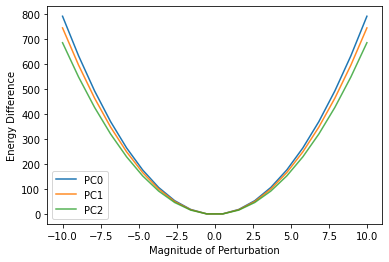

In [13]:
latent_dim = 3
pert_mags = np.linspace(-10,10, num=20)
print(pert_mags)
# get sequence set
sequence_set = s[:2]

# fit pca model to full sequence set: s_train
pca_perturb = PCA(n_components=latent_dim)
pca_perturb_s = pca_perturb.fit_transform(s) # do not pass s_centered to PCA, it will do that in-house


energy_vs_pc = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_pc.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_pc[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_pc[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [14]:
trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full[-1].append(trans_seq_full_out[0])  
print(np.array(trans_seq_full).shape)

(20, 3, 1329)


(4341, 1329)
(4341, 1329)
(4341, 3)
3
translated sequence full dim:  (3, 1329)
(10, 3, 3)
(10, 3, 3)


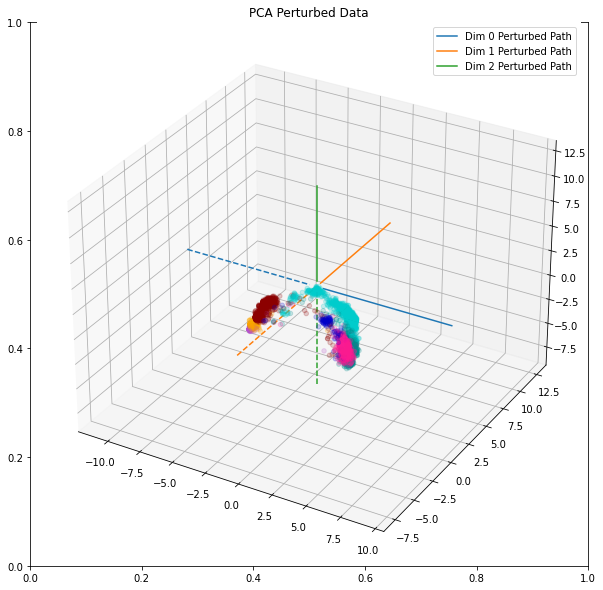

In [15]:

print(s_train.shape)
print(s.shape)
print(s_pca.shape)
perturb_path_full = np.array(trans_seq_full)
print(latent_dim)
print('translated sequence full dim: ', np.array(trans_seq_full[i]).shape)

perturb_path_mag = []
perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        perturb_path_mag.append(pca.transform(trans_seq_full[i]))
    else:
        perturb_path_mag_neg.append(pca.transform(trans_seq_full[i]))
perturb_path_mag = np.array(perturb_path_mag)
perturb_path_mag_neg = np.array(perturb_path_mag_neg)
print(perturb_path_mag.shape)
print(perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('PCA Perturbed Data')
ax = plt.axes(projection='3d')
ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], alpha=.2,c=family_colors)

dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

In [16]:
def ER_transform(seqs, v, mean=None):
    if mean is None:
        seqs_centered = seqs - np.mean(seqs,axis=0)
    else:
        seqs_centered = seqs - mean    
    new_seqs = seqs_centered @ v.T
    return new_seqs

def ER_inverse_transform(seqs, v, mean=None):
    if mean is None:
        new_seqs = seqs @ v
    else:
        new_seqs = seqs @ v
        new_seqs = new_seqs + mean
    return new_seqs
# def ER_perturb(seqs, w, v, pert_mag=1.,mean=None, pert_dir=0):
#     dir_vec = v[pert_dir] 
    
#     # assumes sequences have not been centered
#     # if w is from subset of sequences you need to pass the mean of that subset
#     if mean is None:
#         seqs_centered = seqs - np.mean(seqs,axis=0)
#     else:
#         seqs_centered = seqs - mean
        
#     new_seqs =  seqs_centered.copy()
#     if len(new_seqs.shape)> 1:
#         for i, seq in enumerate(seqs_centered):
#             # print(np.add(seqs[i], pert_mag * dir_vec).shape)
#             new_seqs[i,:] = seq + pert_mag * dir_vec
#     else:
# #         new_seqs = np.add(seqs, pert_mag * dir_vec)
#         new_seqs = seqs + pert_mag * dir_vec
#     return new_seqs
def ER_perturb(seqs, w, v, pert_mag=1., pert_dir=0):
    dir_vec = v[pert_dir] 
    new_seqs =  seqs.copy()
    if len(new_seqs.shape)> 1:
        for i, seq in enumerate(seqs):
            # print(np.add(seqs[i], pert_mag * dir_vec).shape)
            new_seqs[i,:] = seq + pert_mag * dir_vec
    else:
#         new_seqs = np.add(seqs, pert_mag * dir_vec)
        new_seqs = seqs + pert_mag * dir_vec
    return new_seqs

In [17]:
w, v  = np.linalg.eig(w_ER)
print(w.shape)
print(v.shape)
print(w[:5])

trans_seq_full_out = ER_perturb(s[0], w, v, pert_mag=0, pert_dir=0)

print(sequence_set.shape)
print(trans_seq_full_out.shape)
print(sequence_set[0,:10])
print(trans_seq_full_out[:10])

(1329,)
(1329, 1329)
[8.55764338 7.94302541 7.51328172 7.13397248 6.78669699]
(2, 1329)
(1329,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]


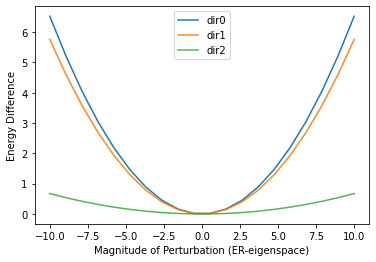

In [18]:
pert_mags = np.linspace(-10,10, num=20)
print(pert_mags)
ref_seq = s[0]

energy_vs_w_ERperturb = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_w_ERperturb.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = ER_perturb(ref_seq, w, v, pert_mag=mag, pert_dir=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out)  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_w_ERperturb[-1].append(energy_diff(i1i2,trans_seq_full,ref_seq,w_ER))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_w_ERperturb[i], alpha = 1-.1*i, label='dir%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation (ER-eigenspace)')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [19]:
wER_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(ref_seq, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_trans_seq_full[-1].append(trans_seq_full_out)  


(10, 3, 3)
(10, 3, 3)


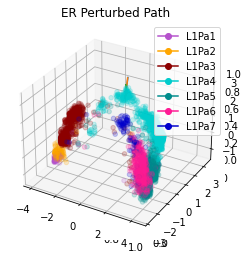

In [20]:
from matplotlib.lines import Line2D
wER_perturb_path_mag = []
wER_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_perturb_path_mag.append(pca.transform(wER_trans_seq_full[i]))
    else:
        wER_perturb_path_mag_neg.append(pca.transform(wER_trans_seq_full[i]))
wER_perturb_path_mag = np.array(wER_perturb_path_mag)
wER_perturb_path_mag_neg = np.array(wER_perturb_path_mag_neg)
print(wER_perturb_path_mag.shape)
print(wER_perturb_path_mag_neg.shape)

# creating figure
figg = plt.figure()
ax = figg.add_subplot(111, projection='3d')
plt.title('ER Perturbed Path')
ax = plt.axes(projection='3d')
ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], alpha=.2,c=family_colors)
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_perturb_path_mag[:,move_dim,0], wER_perturb_path_mag[:,move_dim,1], wER_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_perturb_path_mag_neg[:,move_dim,0], wER_perturb_path_mag_neg[:,move_dim,1], wER_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]

# Create the figure
ax.legend(handles=legend_elements)
plt.show()

## Use w_ER-eig to transform space

In [21]:

s_ER = ER_transform(s,v)
fig = plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

(4341, 1329)
(10, 3, 1329)
(10, 3, 1329)


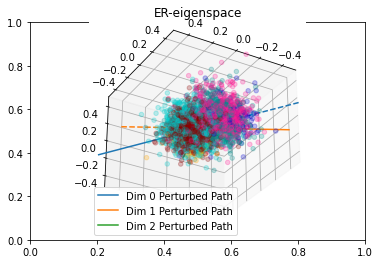

In [22]:

# print(w)
# print(v)
# v_stretch0 = v.copy()
# v_stretch0[0] = v[0]*1000
# s_ER = ER_transform(s,v_stretch0)

print(s_ER.shape)
pert_mags = np.linspace(-1,1, num=20)

wER_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(ref_seq, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_trans_seq_full[-1].append(trans_seq_full_out)  


wER_perturb_path_mag = []
wER_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_perturb_path_mag.append(ER_transform(wER_trans_seq_full[i],v))
    else:
        wER_perturb_path_mag_neg.append(ER_transform(wER_trans_seq_full[i],v))
wER_perturb_path_mag = np.array(wER_perturb_path_mag)
wER_perturb_path_mag_neg = np.array(wER_perturb_path_mag_neg)
print(wER_perturb_path_mag.shape)
print(wER_perturb_path_mag_neg.shape)

plt.title('ER-eigenspace')
ax = plt.axes(projection='3d')
ax.scatter(s_ER[:,0], s_ER[:,1], s_ER[:,2], alpha=.25,c=family_colors)
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_perturb_path_mag[:,move_dim,0], wER_perturb_path_mag[:,move_dim,1], wER_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_perturb_path_mag_neg[:,move_dim,0], wER_perturb_path_mag_neg[:,move_dim,1], wER_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')
ax.set_xlim3d(-.5, .5)
ax.set_zlim3d(-.5, .5)
ax.set_ylim3d(-.5, .5)
plt.legend()
# optimal viewing angle with change between generatinos of w_ER (fit function is stochastic)
ax.view_init(-30,60)

plt.show()
ax.view_init( )
plt.show()


In [23]:
import trimap
print(latent_dim)
trimap_embedder = trimap.TRIMAP(n_dims=3, n_iters=1000)
trimap_embedding = trimap_embedder.fit_transform(s)
print(len(s))
print(len(family_colors))

# print(s_E_dist.shape)
# trimap_ER_embedding = trimap.TRIMAP( use_dist_matrix=True, n_iters=1000).fit_transform(s_E_dist)
# trimap_hamming_embedding = trimap.TRIMAP(n_dims=3, distance='hamming',n_iters=1000).fit_transform(s_train[:100])

3
4341
4341


(4341, 3)


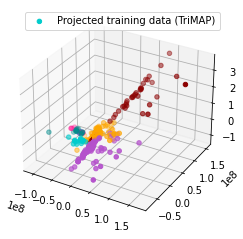

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
print(trimap_embedding.shape)
ax.scatter(trimap_embedding[:,0], trimap_embedding[:,1], trimap_embedding[:,2], c=family_colors, label='Projected training data (TriMAP)')
plt.legend()
plt.show()


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# print(trimap_embedding.shape)
# ax.scatter(trimap_ER_embedding[:,0], trimap_ER_embedding[:,1], trimap_ER_embedding[:,2], c=family_colors, alpha=0.1, label='Projected training data (TriMAP)')
# plt.legend()
# plt.show()

In [25]:
# Get W-er for all families
w_families = []
b_families = []
for msa_id in range(7):
    w_file = "%s/w_%s.npy" % (data_dir,lp_names[msa_id]) 
    b_file = "%s/b_%s.npy" % (data_dir,lp_names[msa_id])        

#     if os.path.exists(w_file):
    if 0:

        w_fam = np.load(w_file)
    else:
        w_fam = np.zeros((mx.sum(),mx.sum()))                                                                     
        h0 = np.zeros(mx.sum()) 
            #-------------------------------                                                                     
        # parallel  
        s_msa = s_train[family_indx[msa_id]]
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_msa,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))                                                                      

        run_time = timeit.default_timer() - start_time                                                       
        print('run time:',run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_fam[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_fam[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric                                                                                   
        w_fam = (w_fam + w_fam.T)/2.   
        np.save(w_file, w_fam)
    b_families.append(h0)
    w_families.append(w_fam)


run time: 49.26600409299135
run time: 28.092012217006413
run time: 27.21985172398854
run time: 28.17664910701569
run time: 27.743242060998455
run time: 56.9783005110221
run time: 42.50350339899887


In [26]:
s_families = [] # list of full msa embeded in all family sequences spaces
for i,w_fam in enumerate(w_families):
    # get sequences space for family
    print(len(family_indx[i]))
    w_f, v_f  = np.linalg.eigh(w_fam)
    fam_mean = np.mean(s[family_indx[i]],axis=0)
    s_families.append(ER_transform(s,v_f, mean = fam_mean))


295
499
1000
1104
741
599
103


## Get two chrono-consecutive families in earliest group space 

L1Pa3
(4341, 1329)
(1000, 3)
(1104, 3)


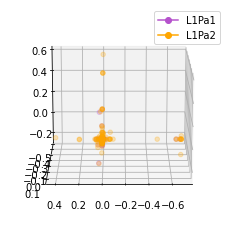

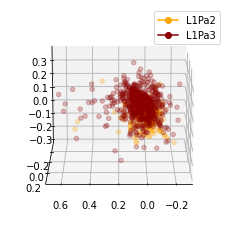

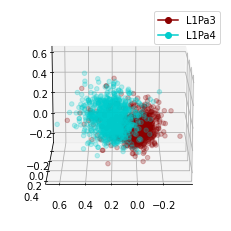

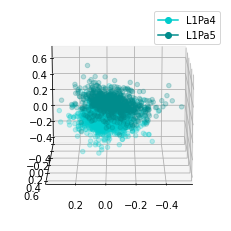

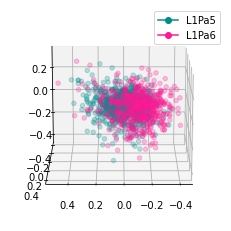

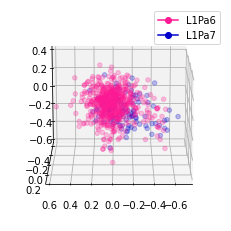

In [27]:
msa_1 = 2

gps = []
for ii, msa in enumerate(s_families):
    gps.append([])
    for i in range(len(s_families)):
        gps[-1].append(np.array(list(zip(msa[family_indx[i],0], msa[family_indx[i],1],msa[family_indx[i],2]))))
        
        
# gp1 = np.array(list(zip(s_families[msa_1][family_indx[msa_1],0], s_families[msa_1][family_indx[msa_1],1],s_families[msa_1][family_indx[msa_1],2])))
gp1 = gps[msa_1][msa_1]
print(lp_names[msa_1])
print(s_families[msa_1].shape)
print(gp1.shape)

msa_2 =msa_1+1
# gp2 = np.array(list(zip(s_families[msa_2][family_indx[msa_2],0], s_families[msa_2][family_indx[msa_2],1],s_families[msa_2][family_indx[msa_2],2])))
gp2 = gps[msa_1][msa_2]
print(gp2.shape)



legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]
for i in range(len(gps)-1):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    gp_a = gps[i][i]
    gp_b = gps[i][i+1]
    ax.scatter(gp_a[:,0], gp_a[:,1], gp_a[:,2],alpha=.25,color=colors[i])
    ax.scatter(gp_b[:,0], gp_b[:,1], gp_b[:,2],alpha=.25,color=colors[i+1])
#     ax.view_init(0,-65)   
    ax.view_init(15,90)  # wfam 2 ***

    ax.legend(handles=legend_elements[i:i+2])

          

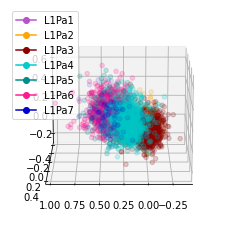

In [28]:
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(len(gps)-1):
    gp_a = gps[2][i]
    gp_b = gps[2][i+1]
    ax.scatter(gp_a[:,0], gp_a[:,1], gp_a[:,2],alpha=.1,color=colors[i])
    ax.scatter(gp_b[:,0], gp_b[:,1], gp_b[:,2],alpha=.1,color=colors[i+1])
#     ax.view_init(45,45)  # wfam 0
#     ax.view_init(45,45)  # wfam 1
    ax.view_init(15,90)  # wfam 2 ***
#     ax.view_init(0,-110)  # wfam 3
#     ax.view_init(15,-85)  # wfam 4
#     ax.view_init(45,95)  # wfam 5
#     ax.view_init(15,90)  # wfam 6

ax.legend(handles=legend_elements)

## Get separating plane and find gp1 point closest to it

In [29]:
from sklearn import svm
gp12 = np.append(gp1, gp2, axis=0)
y = np.zeros(len(gp12))
y[:len(gp1)] = 1
clf = svm.SVC(kernel='linear')
clf.fit(gp12,y)

def perp_dist(x1, y1, z1, a, b, c, d):
     
    d = abs((a * x1 + b * y1 + c * z1 + d))
    e = (math.sqrt(a * a + b * b + c * c))
    return d/e

    
import math
# min_dist = 100.
# print(len(gp1))
# for i, pt in enumerate(gp1):
#     pt_dist = perp_dist(pt[0],pt[1],pt[2], clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.intercept_[0])
#     if pt_dist < min_dist:
#         min_dist = pt_dist
#         min_id = i
# print(min_dist)
# print(min_id)

gp1_mean = np.mean(s[family_indx[msa_1]],axis=0)
# Get closest point to mean precursor
# Get closest point to mean precursor
    
from scipy.spatial.distance import pdist
min_dist = 100000.
print(len(gp1))
for i, msa2_seq in enumerate(s[family_indx[msa_2]]):

    pt_dist = pdist((gp1_mean,msa2_seq))
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = i
print(min_dist)
print(min_id)

1000
[3.78656097]
153


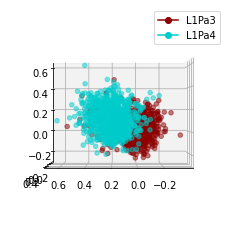

In [30]:
# The equation of the separating plane is given by all x in R^3 such that:
# np.dot(svc.coef_[0], x) + b = 0. We should solve for the last coordinate
# to plot the plane in terms of x and y.

z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-.5,.5,51)
x,y = np.meshgrid(tmp,tmp)
# Plot stuff.
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, z(x,y),alpha=.5)
ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2],alpha=.5,color=colors[msa_1])
ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2],alpha=.5,color=colors[msa_2])
ax.scatter(gp1[min_id,0],gp1[min_id,1],gp1[min_id,2],color='k',s=100)
ax.view_init(0,90)  
ax.legend(handles=legend_elements[msa_1:msa_2+1])

plt.show()

In [31]:
def check_angle(ref_pt, pt1, pt2):
    vec1 = pt1 - ref_pt
    vec2 = pt2 - ref_pt

    mag1 = np.sqrt(np.sum([a**2 for a in vec1]))
    mag2 = np.sqrt(np.sum([a**2 for a in vec2]))

    dot = np.dot(vec1, vec2)
    
    cos_theta = dot / (mag1 * mag2)
    
    return cos_theta

In [32]:
print(len(s_families[msa_1]))
print(len(s_families[msa_1][family_indx[msa_1]]))
boundary_seq = s_families[msa_1][family_indx[msa_2]][min_id]

# boundary_seq = s[family_indx[msa_1]][min_id]

n_dim = w_ER.shape[1]
wER_trans_boundary_seq = []

w, v  = np.linalg.eigh(w_families[msa_1])
print(w)
# for move_dim in range(n_dim):
#     wER_trans_boundary_seq.append([])
pert_mags = np.linspace(0,5., num=2)
print(pert_mags)
wER_pert = []
move_dim = n_dim-1



for i,mag in enumerate(pert_mags):
    print(mag)
    trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
#     wER_trans_boundary_seq[-1].append(trans_seq_full_out)  
    wER_pert.append(trans_seq_out)
print(len(wER_pert))

# wER_pert_trans = ER_transform(wER_pert,v)
wER_pert_trans = np.array(wER_pert)
print(len(wER_pert_trans))
print(len(wER_pert_trans[0]))

print(wER_pert_trans[0][0],wER_pert_trans[0][1],wER_pert_trans[0][2])
print(gp1[min_id,0],gp1[min_id,1],gp1[min_id,2])

4341
1000
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]
[0. 5.]
0.0
5.0
2
2
1329
0.008 0.009 0.004
0.09967525357191921 -0.10737605059479781 -0.047729465593159964


3


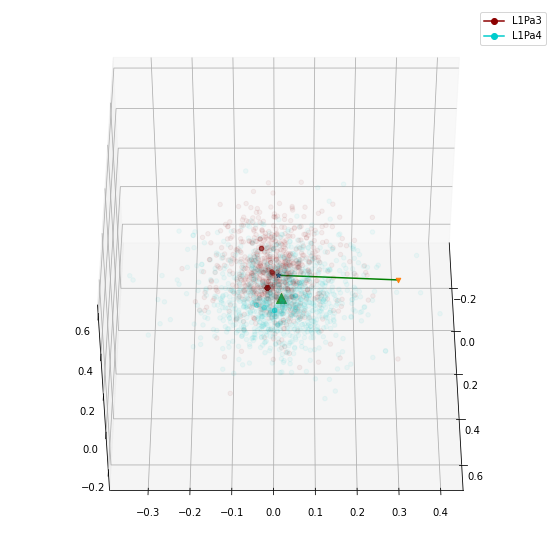

In [33]:

print(len(gp1[0]))

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, z(x,y),alpha=.5)
ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2],alpha=.05,color=colors[msa_1])
ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2],alpha=.05,color=colors[msa_2])
ax.scatter(gp1_mean[0],gp1_mean[1],gp1_mean[2],marker='*',color='k')
ax.view_init(0,90)       
# ax.view_init(15,90)  # wfam 2 ***

ax.legend(handles=legend_elements[msa_1:msa_2+1])

ax.scatter(wER_pert_trans[0,0], wER_pert_trans[0,1], wER_pert_trans[0,2],marker='*')
gp2_mean = np.mean(gp2,axis=0)
    
cos_theta = check_angle(gp1_mean[:3], wER_pert_trans[-1,:3],boundary_seq[:3])
if cos_theta > 0.:        
    ax.plot(wER_pert_trans[:,0], wER_pert_trans[:,1], wER_pert_trans[:,2], color='g')
else:
    ax.plot(wER_pert_trans[:,0], wER_pert_trans[:,1], wER_pert_trans[:,2], color='r')
ax.scatter(wER_pert_trans[-1,0], wER_pert_trans[-1,1], wER_pert_trans[-1,2],marker='v')
ax.scatter(gp2_mean[0], gp2_mean[1], gp2_mean[2],marker='^',s=100)

ax.view_init(45,0)  
plt.show()

## Track the evolutionary path from one family to the next

295
[1.39223438]
7
295
499
[2.00161982]
21
499
1000
[3.78656097]
153
1000
1104
[3.72777647]
90
1104
741
[2.45349251]
403
741
599
[4.42659264]
73
599


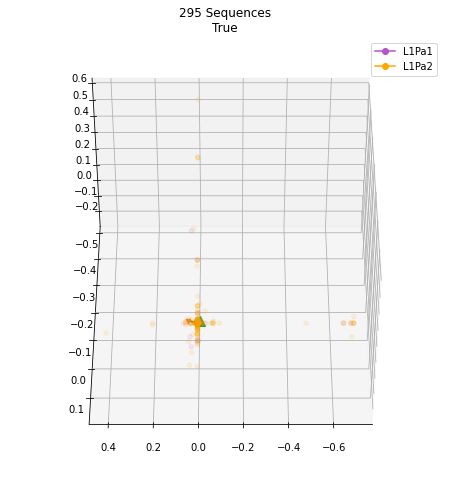

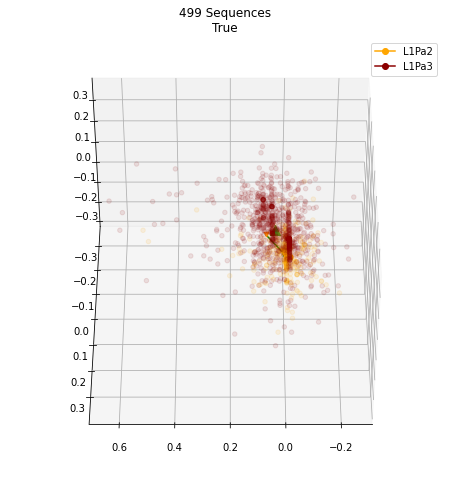

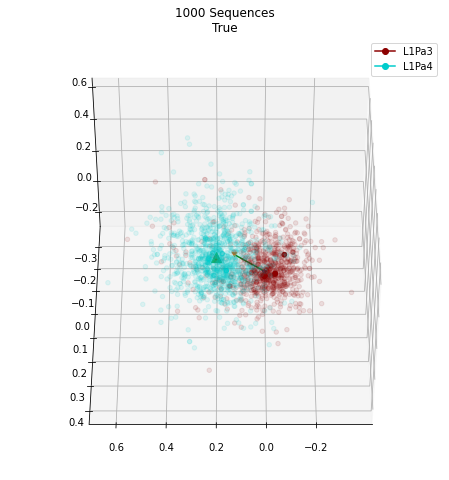

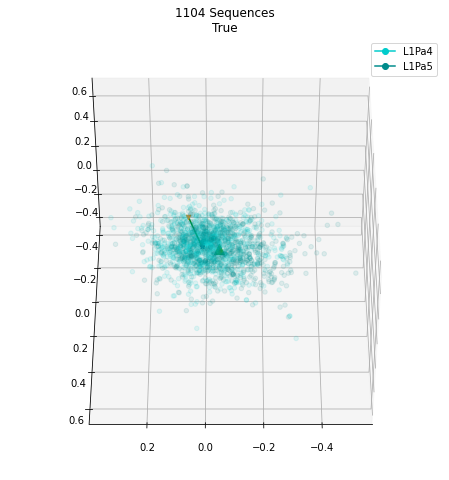

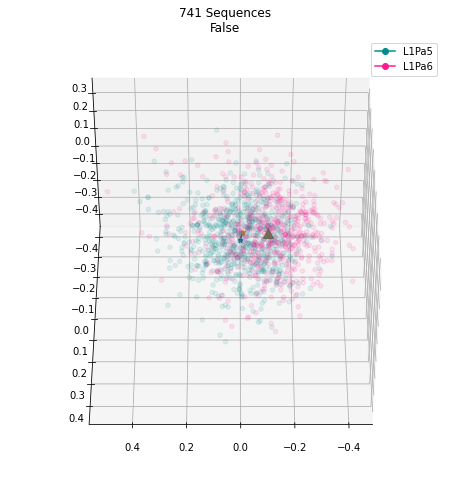

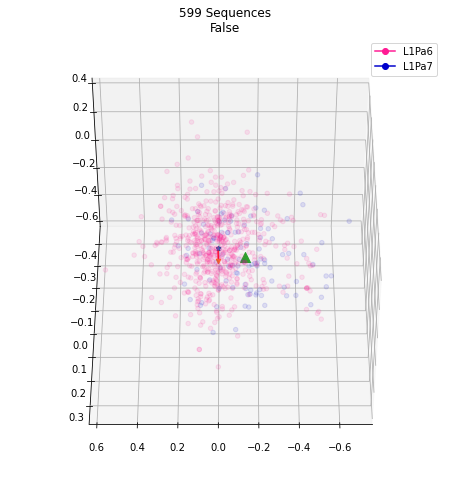

In [34]:
n_dim = w_ER.shape[1]
pert_mags = np.linspace(0,5., num=2)
move_dim = n_dim-1
move_dim = 0

for i in range(len(gps)-1):
#     # Get separating plane
    gp1 = gps[i][i]
    gp2 = gps[i][i+1]    
#     gp12 = np.append(gp1, gp2, axis=0)
#     y = np.zeros(len(gp12))
#     y[:len(gp1)] = 1
#     clf = svm.SVC(kernel='linear')
#     clf.fit(gp12,y)
    

#     z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]

#     tmp = np.linspace(-.5,.5,51)
#     x,y = np.meshgrid(tmp,tmp)
    
#     # get closest precursor sequence to separating plane
#     min_dist = 100000.
#     for ii, pt in enumerate(gp1):
#         pt_dist = perp_dist(pt[0],pt[1],pt[2], clf.coef_[0][0],clf.coef_[0][1],clf.coef_[0][2],clf.intercept_[0])
#         if pt_dist < min_dist:
#             min_dist = pt_dist
#             min_id = ii    


    gp1_mean = np.mean(s[family_indx[i]],axis=0)
    # Get closest point to mean precursor

    min_dist = 100000.
    print(len(gp1))
    for ii, msa2_seq in enumerate(s[family_indx[i+1]]):

        pt_dist = pdist((gp1_mean,msa2_seq))
        if pt_dist < min_dist:
            min_dist = pt_dist
            min_id = ii
    print(min_dist)
    print(min_id)

           
    # perturb closest precursor
    boundary_seq = s_families[i][family_indx[i+1]][min_id]

    wER_trans_boundary_seq = []

    w, v  = np.linalg.eigh(w_families[i])
    wER_pert = []
    for iii,mag in enumerate(pert_mags):
        trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_pert.append(trans_seq_out)
    wER_pert = np.array(wER_pert)

    
    # plot 
    print(len(gp1))
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2],alpha=.1,color=colors[i])
    ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2],alpha=.1,color=colors[i+1])
#     ax.view_init(0,-65)   
    ax.view_init(45,90)  # wfam 2 ***

    ax.legend(handles=legend_elements[i:i+2])
    ax.scatter(gp1_mean[0],gp1_mean[1],gp1_mean[2],marker='*',color='k')
    # ax.view_init(15,90)  # wfam 2 ***


    ax.scatter(wER_pert[0,0], wER_pert[0,1], wER_pert[0,2],marker='*')
    gp2_mean = np.mean(gp2,axis=0)

    cos_theta = check_angle(gp1_mean[:3], wER_pert_trans[-1,:3],boundary_seq[:3])
    if cos_theta > 0.:        
        ax.plot(wER_pert[:,0], wER_pert[:,1], wER_pert[:,2], color='g')
    else:
        ax.plot(wER_pert[:,0], wER_pert[:,1], wER_pert[:,2], color='r')

    ax.scatter(wER_pert[-1,0], wER_pert[-1,1], wER_pert[-1,2],marker='v')
    ax.scatter(gp2_mean[0], gp2_mean[1], gp2_mean[2],marker='^',s=100)
    ax.set_title('%s Sequences\n%s'%(len(gp1),str(cos_theta>0.)))
    
    

## Plot Iso-Energy Contours from reference sequence

In [35]:
msa_1 = 2
msa_2 =msa_1+1

gps = []
for ii, msa in enumerate(s_families):
    gps.append([])
    for i in range(len(s_families)):
        gps[-1].append(np.array(list(zip(msa[family_indx[i],0], msa[family_indx[i],1],msa[family_indx[i],2]))))
        
        
# gp1 = np.array(list(zip(s_families[msa_1][family_indx[msa_1],0], s_families[msa_1][family_indx[msa_1],1],s_families[msa_1][family_indx[msa_1],2])))
gp1 = gps[msa_1][msa_1]
print(lp_names[msa_1])
print(s_families[msa_1].shape)
print(gp1.shape)

# gp2 = np.array(list(zip(s_families[msa_2][family_indx[msa_2],0], s_families[msa_2][family_indx[msa_2],1],s_families[msa_2][family_indx[msa_2],2])))
gp2 = gps[msa_1][msa_2]
print(gp2.shape)

gp12 = np.append(gp1, gp2, axis=0)
max_x = max(gp12[:,0])
min_x = min(gp12[:,0])

max_y = max(gp12[:,1])
min_y = min(gp12[:,1])
print('max/min y/x: ', min_x,max_x,min_y,max_y)


L1Pa3
(4341, 1329)
(1000, 3)
(1104, 3)
max/min y/x:  -0.3495038391991204 0.6359591452841825 -0.33858102932495426 0.39980288347651816


In [36]:
full_dist = np.load('furano_E_dist.npy')
print(full_dist.shape)

(4341, 4341)


In [37]:
# Get sequence energy difference between all sequences and the mean of gp1
gp12_indx = np.append(family_indx[msa_1], family_indx[msa_2], axis = 0)
print(gp12_indx.shape)
print(gp12_indx)

gp1_mean = np.mean(s[family_indx[msa_1]],axis=0)
w_gp1 = w_families[msa_1]


(2104,)
[1898 1899 1900 ... 1101 1102 1103]


In [38]:
# for i in range(len(s)):
#     s_E_row[i] = energy_diff(i1i2,gp1_mean,s[i,:],w_gp1)
# print(s_E_row)
if 1:
    s_E_rows = []
    for msa_indx, w_fam in enumerate(w_families):
        gp_mean = np.mean(s[family_indx[msa_indx]], axis=0)
        s_E_row = np.zeros(len(s))
        res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
                (i1i2,gp_mean,full_s[i0,:],w_fam)
                for i0 in range(len(s)))
        s_E_row = np.array(res)
        print(s_E_row.shape)
        s_E_rows.append(s_E_row)
        np.save('gp%d_SvsAVG_energy.npy' % msa_indx, s_E_row)

else:
    s_E_rows = []
    for i in range(len(gps)):
        s_E_rows.append(np.load('gp%d_SvsAVG_energy.npy' % i))
    print(s_E_rows)
    s_E_row = s_E_rows[msa_1]


(4341,)
(4341,)
(4341,)
(4341,)
(4341,)
(4341,)
(4341,)


In [39]:
# Get closest point to mean precursor

min_dist = 100000.
print(len(gp1))
for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):

    pt_dist = pdist((gp1_mean,msa2_seq))
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = ii
print(min_dist)
print(min_id)


# perturb closest precursor
boundary_seq = s_families[msa_1][family_indx[msa_2]][min_id]

wER_trans_boundary_seq = []

w, v  = np.linalg.eigh(w_gp1)
print(w)
wER_pert = []
move_dim = 0
for iii,mag in enumerate(pert_mags):
    trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
    wER_pert.append(trans_seq_out)
wER_pert = np.array(wER_pert)

1000
[3.78656097]
153
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]


In [40]:
# x = gp12[:,0]
# y = gp12[:,1]
# z = s_E_row

# fig = plt.figure(figsize=(15,10))
# ax  = fig.add_subplot(111)

# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

# # fig.colorbar(cntr2, ax=ax)
# ax.scatter(gp1[:,0], gp1[:,1],alpha=.1,color=colors[msa_1])
# ax.scatter(gp2[:,0], gp2[:,1],alpha=.1,color=colors[msa_2])# ax.set(xlim=(-2, 2), ylim=(-2, 2))
# # ax.set_title('tricontour (%d points)' % npts)
# cos_theta = check_angle(gp1_mean[:2], wER_pert_trans[-1,:2],boundary_seq[:2])
# if cos_theta > 0.:        
#     ax.plot(wER_pert[:,0], wER_pert[:,1], color='g')
# else:
#     ax.plot(wER_pert[:,0], wER_pert[:,1], color='r')
# ax.scatter(wER_pert[-1,0], wER_pert[-1,1],marker='^',color='k')
# ax.scatter(gp1_mean[0], gp1_mean[1], marker='^',color=colors[msa_1],s=100)
# ax.scatter(boundary_seq[0], boundary_seq[1], marker='*',color='k',s=100)

# # plt.subplots_adjust(hspace=0.5)
# plt.show()

In [41]:
# # generate meshgrid for first dim dimensions
# dim = 2
# npts = 100
# mesh_axes = []
# for i in range(dim):
#     m_ax = np.linspace(min(gp12[:,i])+-.1,max(gp12[:,i]+.1),npts)
#     mesh_axes.append(m_ax)
    
#     from sklearn.neighbors import KernelDensity
# from scipy import stats
# print(s[gp12_indx,i].shape)
# print(s[gp12_indx,i].reshape(-1, 1).shape)

# # generate gaussian kernel for higher dimensions of wER eigenspace.
# kernels = []
# for i in range(2,s.shape[1]):
# #     kde = stats.gaussian_kde(s_families[msa_1][gp12_indx][:,i])
#     kde = KernelDensity(bandwidth=0.01).fit(s_families[msa_1][gp12_indx,i].reshape(-1, 1))
#     kernels.append(kde)

# # generate wER-eigenspace grid
# seq_matrix = np.zeros((npts, npts, len(s[0])))
# print(seq_matrix.shape)
# for i in range(npts):
#     x = mesh_axes[0][i]
#     for j in range(npts):
#         y = mesh_axes[1][j]
#         seq = np.append([x,y], [kernels[jj].sample(1) for jj in range(s.shape[1]-2)])
#         seq_matrix[i,j,:] = seq
        
# # transform back to sequence space
# w, v  = np.linalg.eigh(w_gp1)
# fam_mean = np.mean(s[family_indx[msa_1]],axis=0)
# seq_mat_flat = seq_matrix.reshape(-1, seq_matrix.shape[-1])
# print(seq_mat_flat.shape)

# print(fam_mean.shape)
# print(seq_mat_flat.shape)
# eigen_grid_sequences = ER_inverse_transform(seq_mat_flat, v, mean=fam_mean)

# print(eigen_grid_sequences[0])
# eigen_grid_matrix = eigen_grid_sequences.reshape(npts,npts,len(eigen_grid_sequences[0]))
# print(eigen_grid_matrix.shape)
# Z = np.zeros((npts,npts))
# for i in range(npts):
#     for j in range(npts):
#         Z[i,j] = energy_diff(i1i2,gp1_mean,eigen_grid_matrix[i,j,:],w_gp1)
        

In [42]:
# plt.contour(mesh_axes[0], mesh_axes[1], Z)

# Sequence Energy Difference in PCA-space
                   

In [43]:
# PCA space contours.
from sklearn.decomposition import PCA

indx_12 = np.concatenate((family_indx[msa_1],family_indx[msa_2]))

pca = PCA(n_components=2).fit(s[indx_12])                                                                         
pca_s = pca.transform(s)
print('original sequences shape: ', s_train.shape)                                                   
print('pca-embed: ', pca.components_.shape)                                                          
                                                                                                     

x = pca_s[indx_12,0]
y = pca_s[indx_12,1]
z = s_E_row[indx_12]

original sequences shape:  (4341, 1329)
pca-embed:  (2, 1329)


[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]


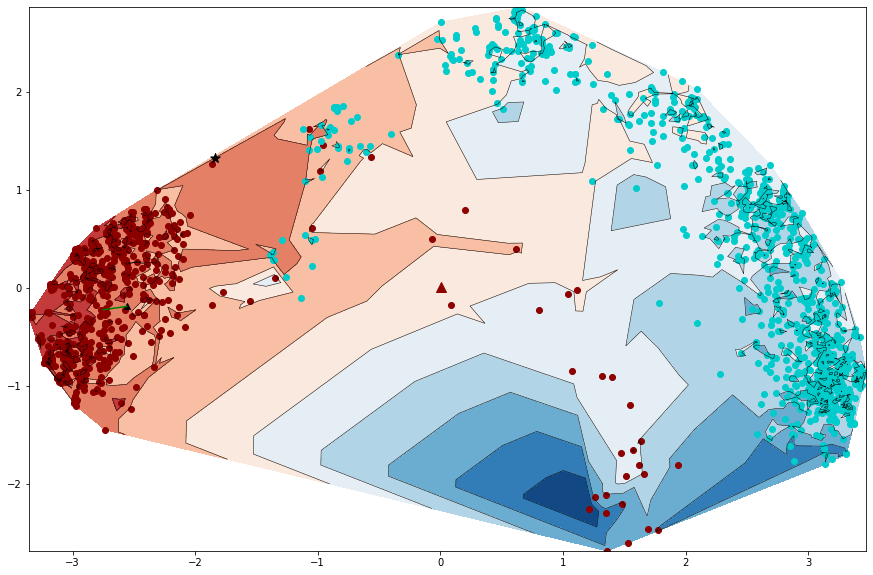

In [44]:
from scipy.ndimage.filters import gaussian_filter

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)



ax.tricontour(x,y,z, levels=10, linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(x,y,z, levels=10, cmap="RdBu_r")

ax.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1])  
ax.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2])                                                                               



# perturb closest precursor
boundary_seq = s_pca[family_indx[msa_2]][min_id]

wER_trans_boundary_seq = []

w, v  = np.linalg.eigh(w_gp1)
print(w)
wER_pert = []
move_dim = 0
for iii,mag in enumerate(pert_mags):
    trans_seq_out = ER_perturb(gp1_mean, w,v, pert_mag=mag, pert_dir=move_dim)
    wER_pert.append(trans_seq_out)
wER_pert = np.array(wER_pert)
pca_wER_pert = pca.transform(wER_pert)


cos_theta = check_angle(gp1_mean[:2], wER_pert_trans[-1,:2], boundary_seq[:2])
if cos_theta > 0.:        
    ax.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='g')
else:
    ax.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='r')
ax.scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
ax.scatter(gp1_mean[0], gp1_mean[1], marker='^',color=colors[msa_1],s=100)
ax.scatter(boundary_seq[0], boundary_seq[1], marker='*',color='k',s=100)


plt.show()

In [45]:
gp2_mean = np.mean(s[family_indx[msa_2]],axis=0)
w_gp2 = w_families[msa_2]
# s_E_row_post = np.zeros(len(s))
# for i in range(len(s)):
#     s_E_row_post[i] = energy_diff(i1i2,gp2_mean,s[i,:],w_gp1)
# print(s_E_row_post)


res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
        (i1i2,gp2_mean,s[i0,:],w_gp2)
        for i0 in range(len(s)))
s_E_row_post = np.array(res)
print(s_E_row.shape)

(4341,)


original sequences shape:  (4341, 1329)
pca-embed:  (2, 1329)
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 89.94808339043962
 88.48904953563294 87.03001568082624 85.57098182601956 84.11194797121289
 82.65291411640618 81.1938802615995 79.73484640679283 78.27581255198612
 77.4110477896863 76.96141590666613 76.51178402364597 76.06215214062581
 75.61252025760567 75.16288837458549 74.71325649156535 74.26362460854519
 73.81399272552503 73.36436084250487 72.9147289594847 72.46509707646455
 72.01546519344438 71.56583331042422 71.11620142740406 70.66656954438392
 70.21693766136374 69.7673057783436 69.31767389532344 68.86804201230328
 68.4184101292831 67.96877824626296 67.5191463632428 67.06951448022264
 66.61988259720249 66.17025071418232 65.72061883116216 65.270986948142
 64.82135506512185 64.37172318210168 63.92209129908153 63.47245941606136
 63.02

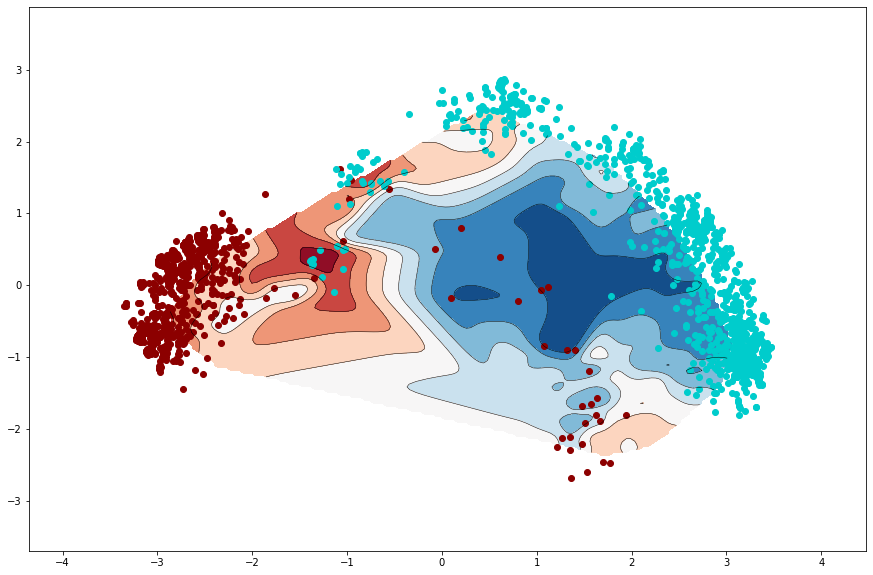

In [46]:
import matplotlib.tri as tri
msa_1 = 2
msa_2 =msa_1+1

indx_12 = np.concatenate((family_indx[msa_1],family_indx[msa_2]))

pca = PCA(n_components=2).fit(s[indx_12])                                                                         
pca_s = pca.transform(s)
print('original sequences shape: ', s_train.shape)                                                   
print('pca-embed: ', pca.components_.shape)                                                          
                                                                                                    

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)
x = pca_s[:,0]
y = pca_s[:,1]
z = s_E_row_post

# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x)-1, max(x)+1, ngridx)
yi = np.linspace(min(y)-1, max(y)+1, ngridy)

# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
# interpolator = tri.CubicTriInterpolator(triang, z)

print(interpolator)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
print(zi[50])
Zi = gaussian_filter(zi, sigma=2.)
# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
ax.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")
print(min(xi))
print(min(pca_s[family_indx[msa_1],0]))
print(cntr1)

ax.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1])  
ax.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2])                                                                               

plt.show()
    

In [47]:
def move_seq(w_gp, seq, move_dim='min',mag=1.):
    wER_trans_boundary_seq = []
    wER_pert = []

    w, v  = np.linalg.eigh(w_gp)
    print(w)
    if move_dim == 'min':
        move_dim = list(w).index(min(w))
    elif move_dim == 'max':
        move_dim = list(w).index(max(w))
        
    for iii,mag in enumerate(pert_mags):
        trans_seq_out = ER_perturb(seq, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_pert.append(trans_seq_out)
    wER_pert = np.array(wER_pert)
    return wER_pert


(590,)
[-0.89179024 -0.6119022  -0.57219289 ...  1.51149352  1.94755591
  3.49594363]
(998,)
[-1.96018488 -1.65774705 -1.41625101 ...  2.35718893  2.41907978
  4.53961225]
(2000,)
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]
(1482,)
[-4.72490482 -4.35455391 -4.06111926 ...  5.34744509  6.09853272
  7.05570121]
(1198,)
[-3.96652841 -3.92908687 -3.66547735 ...  4.74078233  5.68136813
  6.67799629]
(206,)
[-4.02929689 -3.78271751 -3.6831816  ...  4.43913846  5.49993067
  5.97659587]


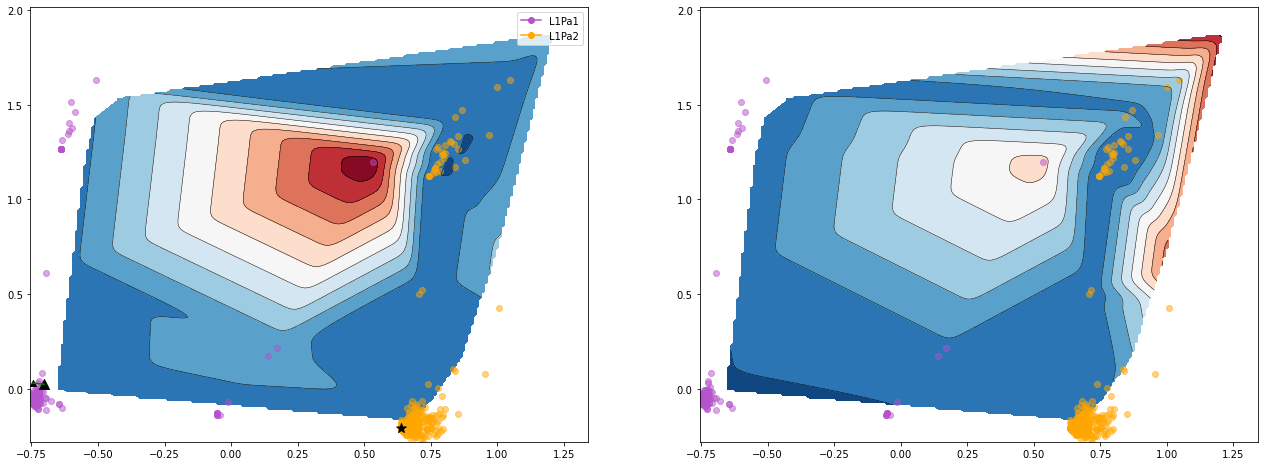

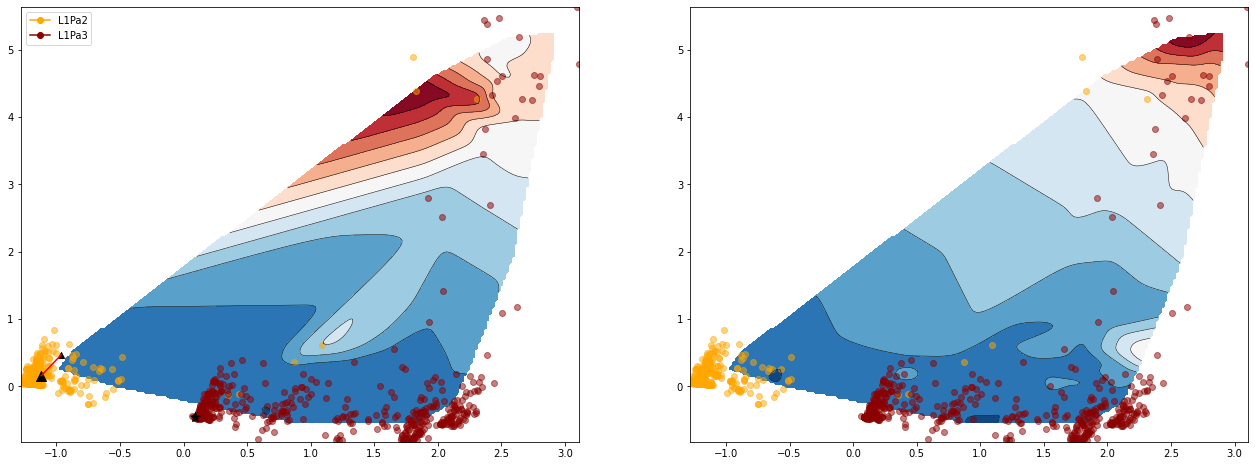

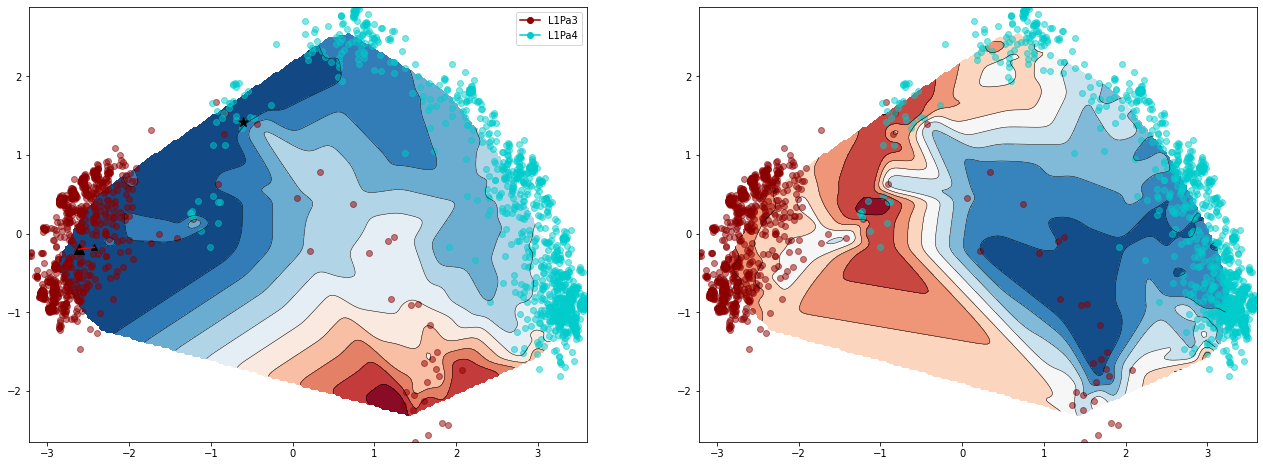

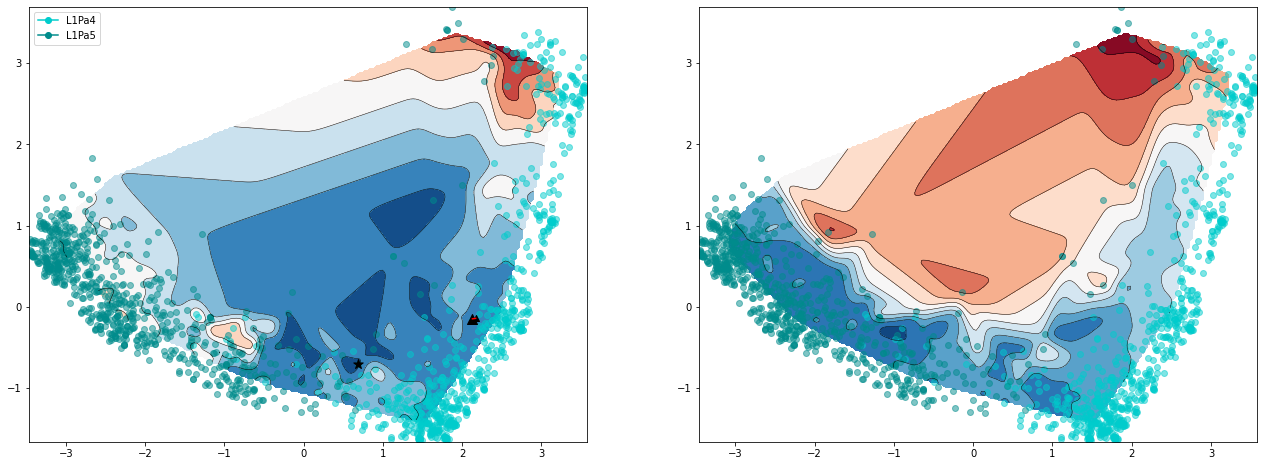

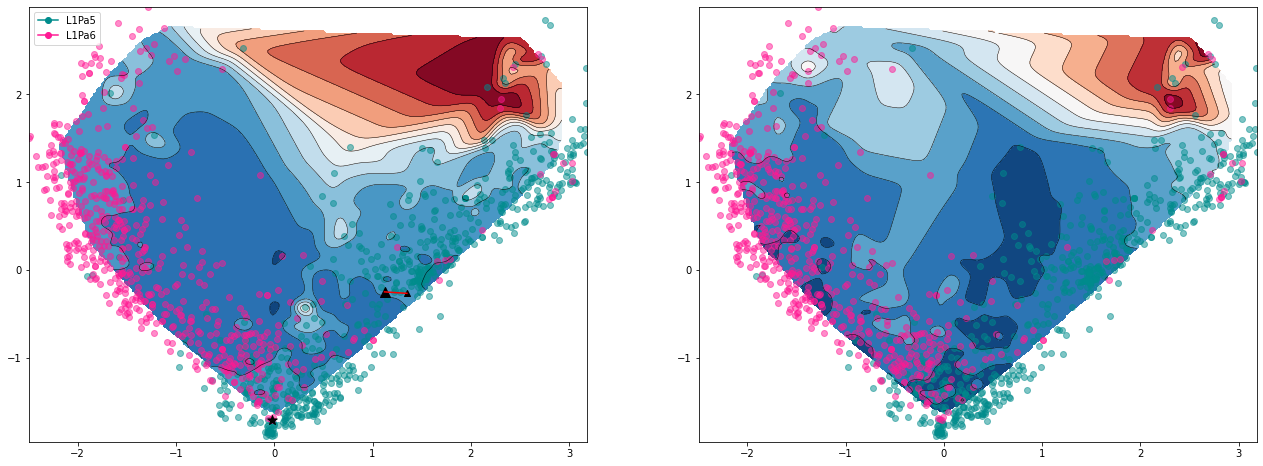

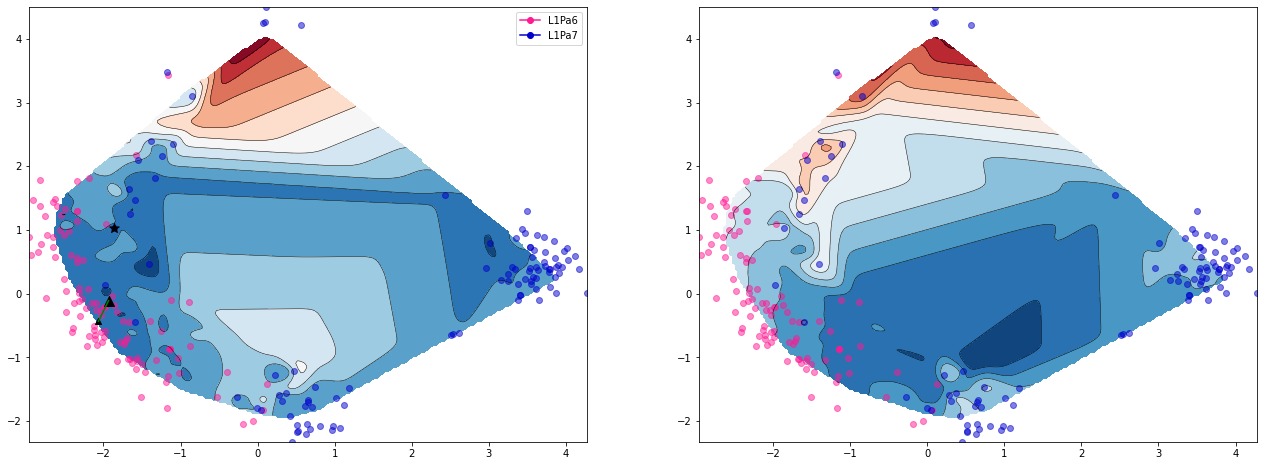

In [48]:


import random
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', label=lp_names[i]) for i in range(7)]

# get all possible samplings from families for consistent grouping 
random_family_indx = []
for i in range(len(w_families)):
    random_family_indx.append( random.sample(family_indx[i], len(family_indx[i])))


for i in range(len(w_families)-1):
    fig = plt.figure(figsize=(22,8))
    ax1  = fig.add_subplot(121)    
    ax2  = fig.add_subplot(122)    

    msa_1 = i
    msa_2 =msa_1+1

    # get sequence count to sample
    sample_size = min(len(family_indx[msa_1]), len(family_indx[msa_2]))
    gp1_indx = random_family_indx[msa_1][:sample_size]
    gp2_indx = random_family_indx[msa_2][:sample_size]


    
    gp1_mean = np.mean(s[gp1_indx],axis=0)
    gp2_mean = np.mean(s[gp2_indx],axis=0)
    w_gp1 = w_families[msa_1]
    w_gp2 = w_families[msa_2]
    
    print(np.concatenate((gp1_indx,gp2_indx)).shape)
    indx_12 = np.concatenate((gp1_indx,gp2_indx))
    indx_12_full = np.concatenate((family_indx[msa_1],family_indx[msa_2]))
    s_12 = s[indx_12]
    pca = PCA(n_components=2).fit(s_12)                                                                   
    pca_s = pca.transform(s)
    gp1_mean_pca = pca.transform([gp1_mean])[0]

    z1 = s_E_rows[msa_1][indx_12_full]
    z2 = s_E_rows[msa_2][indx_12_full]

    

    x = pca_s[indx_12_full,0]
    y = pca_s[indx_12_full,1]


    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)
    
    interpolator1 = tri.LinearTriInterpolator(triang, z1)
    interpolator2 = tri.LinearTriInterpolator(triang, z2)

    # interpolator = tri.CubicTriInterpolator(triang, z)

    Xi, Yi = np.meshgrid(xi, yi)
    
    zi1 = interpolator1(Xi, Yi)
    Zi1 = gaussian_filter(zi1, sigma=2.)
    
    zi2 = interpolator2(Xi, Yi)
    Zi2 = gaussian_filter(zi2, sigma=2.)    
    
    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    ax1.contour(Xi, Yi, Zi1, levels=10, linewidths=0.5, colors='k')
    cntr11 = ax1.contourf(Xi, Yi, Zi1, levels=10, cmap="RdBu_r")
    ax2.contour(Xi, Yi, Zi2, levels=10, linewidths=0.5, colors='k')
    cntr12 = ax2.contourf(Xi, Yi, Zi2, levels=10, cmap="RdBu_r")   

    # plot the sequence points for both families
#     ax1.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1],alpha=.5)  
#     ax1.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2],alpha=.5)                                                                               
#     ax2.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1],alpha=.5)  
#     ax2.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2],alpha=.5)                                                                               
    ax1.scatter(pca_s[gp1_indx,0], pca_s[gp1_indx,1], color=colors[msa_1],alpha=.5)  
    ax1.scatter(pca_s[gp2_indx,0], pca_s[gp2_indx,1], color=colors[msa_2],alpha=.5)                                                                               
    ax2.scatter(pca_s[gp1_indx,0], pca_s[gp1_indx,1], color=colors[msa_1],alpha=.5)  
    ax2.scatter(pca_s[gp2_indx,0], pca_s[gp2_indx,1], color=colors[msa_2],alpha=.5)                                                                               

    
    # plot the mean value perturbed and the boundary sequence of the descendant
    # fin closest descendant
    min_dist = 100000.
    for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
        pt_dist = pdist((gp1_mean,msa2_seq))
        if pt_dist < min_dist:
            min_dist = pt_dist
            min_id = ii
    boundary_seq = s[family_indx[msa_2]][min_id]
    boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]
    
    wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
    pca_wER_pert = pca.transform(wER_pert)

    cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
    if cos_theta > 0.:        
        ax1.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='g')
    else:
        ax1.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='r')
    ax1.scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
    ax1.scatter(gp1_mean_pca[0], gp1_mean_pca[1], marker='^',color='k',s=100)
    ax1.scatter(boundary_seq_pca[0], boundary_seq_pca[1], marker='*',color='k',s=100)


    ax1.legend(handles=legend_elements[i:i+2])
    

(794,)
[-0.89179024 -0.6119022  -0.57219289 ...  1.51149352  1.94755591
  3.49594363]
(1499,)
[-1.96018488 -1.65774705 -1.41625101 ...  2.35718893  2.41907978
  4.53961225]
(2104,)
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]
(1845,)
[-4.72490482 -4.35455391 -4.06111926 ...  5.34744509  6.09853272
  7.05570121]
(1340,)
[-3.96652841 -3.92908687 -3.66547735 ...  4.74078233  5.68136813
  6.67799629]
(702,)
[-4.02929689 -3.78271751 -3.6831816  ...  4.43913846  5.49993067
  5.97659587]


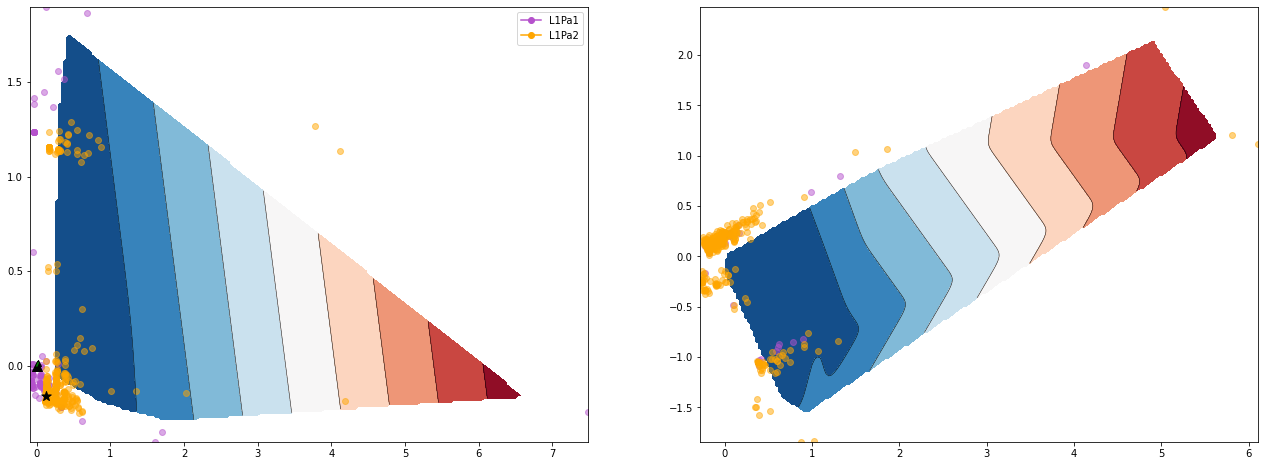

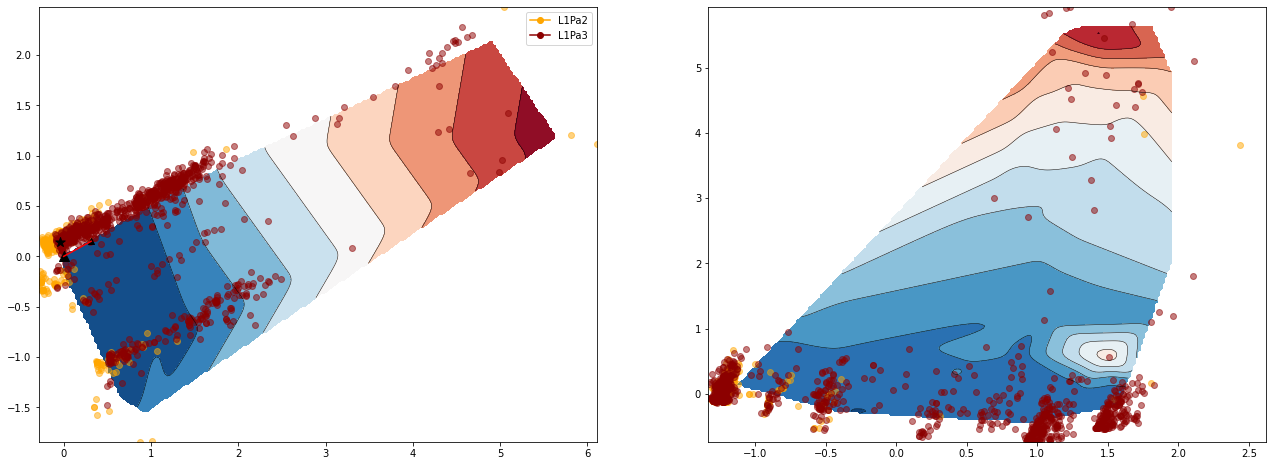

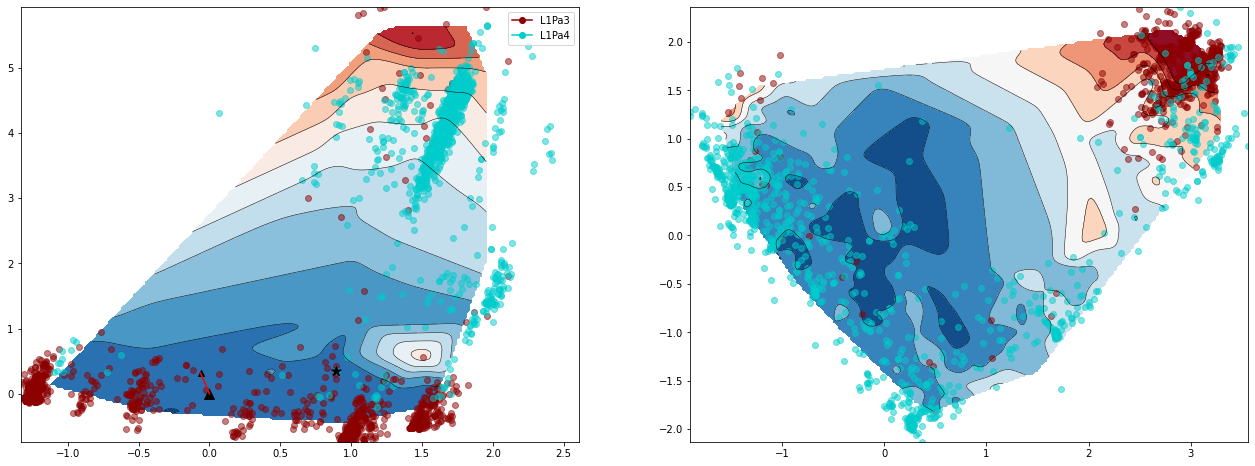

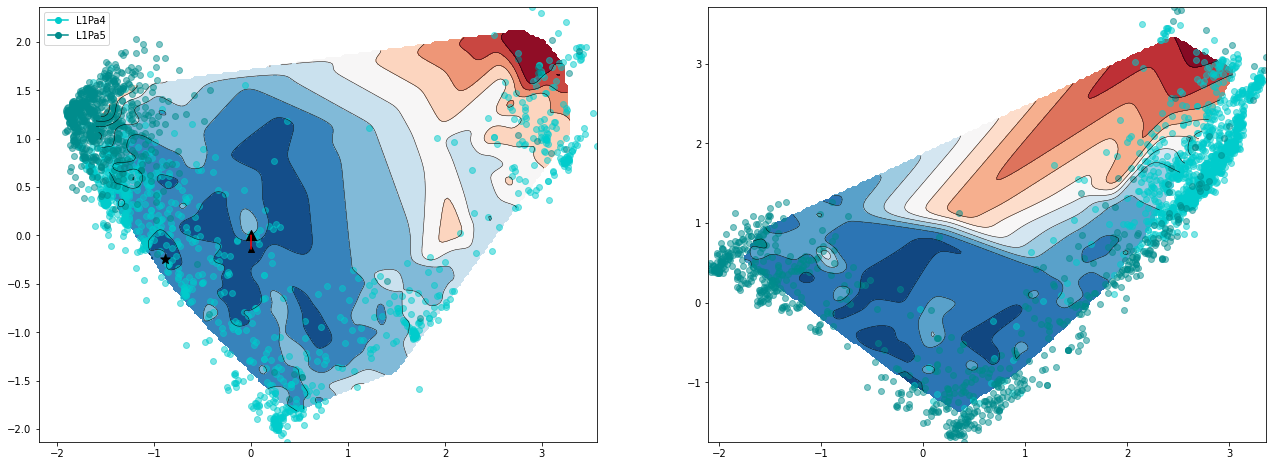

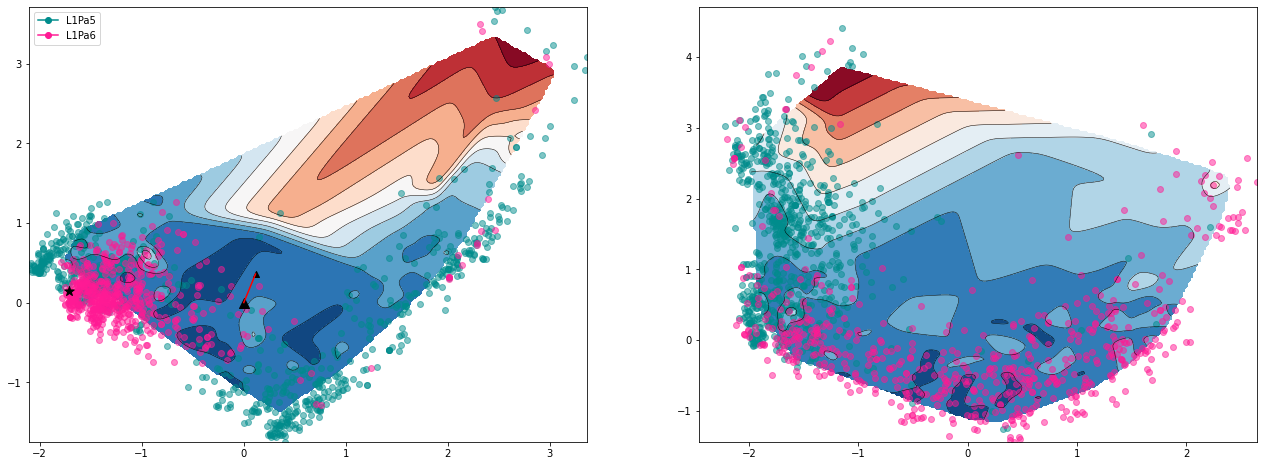

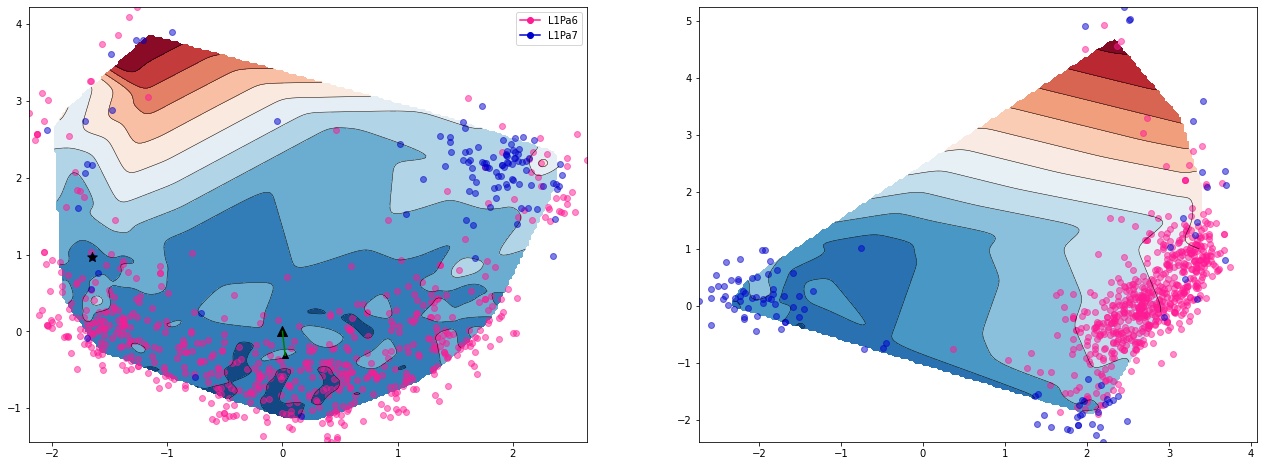

In [49]:
use_full = True

for i in range(len(w_families)-1):
    fig = plt.figure(figsize=(22,8))
    ax1  = fig.add_subplot(121)    
    ax2  = fig.add_subplot(122)    

    msa_1 = i
    msa_2 =msa_1+1

    # get sequence count to sample
    if use_full:
        gp1_indx = family_indx[msa_1]
        gp2_indx = family_indx[msa_2]       
    else:
        sample_size = min(len(family_indx[msa_1]), len(family_indx[msa_2]))
        gp1_indx = random_family_indx[msa_1][:sample_size]
        gp2_indx = random_family_indx[msa_2][:sample_size]

    print(np.concatenate((gp1_indx,gp2_indx)).shape)


    gp1_mean = np.mean(s[gp1_indx],axis=0)
    gp2_mean = np.mean(s[gp2_indx],axis=0)
    w_gp1 = w_families[msa_1]
    w_gp2 = w_families[msa_2]
    
    indx_12 = np.concatenate((gp1_indx, gp2_indx))
    s_12 = s[indx_12]
    pca1 = PCA(n_components=2).fit(s[gp1_indx])  
    pca2 = PCA(n_components=2).fit(s[gp2_indx])                                                                   

    pca1_s = pca1.transform(s)
    pca2_s = pca2.transform(s)

    gp1_mean_pca = pca1.transform([gp1_mean])[0]

    z1 = s_E_rows[msa_1][family_indx[msa_1]]
    z2 = s_E_rows[msa_2][family_indx[msa_2]]

    x1 = pca1_s[family_indx[msa_1],0]
    y1 = pca1_s[family_indx[msa_1],1]
    x2 = pca2_s[family_indx[msa_2],0]
    y2 = pca2_s[family_indx[msa_2],1]


    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi1 = np.linspace(min(x1), max(x1), ngridx)
    yi1 = np.linspace(min(y1), max(y1), ngridy)
    xi2 = np.linspace(min(x2), max(x2), ngridx)
    yi2 = np.linspace(min(y2), max(y2), ngridy)
    
    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang1 = tri.Triangulation(x1, y1)
    triang2 = tri.Triangulation(x2, y2)
    
    interpolator1 = tri.LinearTriInterpolator(triang1, z1)
    interpolator2 = tri.LinearTriInterpolator(triang2, z2)

    # interpolator = tri.CubicTriInterpolator(triang, z)

    Xi1, Yi1 = np.meshgrid(xi1, yi1)
    Xi2, Yi2 = np.meshgrid(xi2, yi2)

    zi1 = interpolator1(Xi1, Yi1)
    Zi1 = gaussian_filter(zi1, sigma=2.)
    
    zi2 = interpolator2(Xi2, Yi2)
    Zi2 = gaussian_filter(zi2, sigma=2.)    
    
    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    ax1.contour(Xi1, Yi1, Zi1, levels=10, linewidths=0.5, colors='k')
    cntr11 = ax1.contourf(Xi1, Yi1, Zi1, levels=10, cmap="RdBu_r")
    ax2.contour(Xi2, Yi2, Zi2, levels=10, linewidths=0.5, colors='k')
    cntr12 = ax2.contourf(Xi2, Yi2, Zi2, levels=10, cmap="RdBu_r")   

    # plot the sequence points for both families
#     ax1.scatter(pca1_s[family_indx[msa_1],0], pca1_s[family_indx[msa_1],1], color=colors[msa_1],alpha=.5)  
#     ax1.scatter(pca1_s[family_indx[msa_2],0], pca1_s[family_indx[msa_2],1], color=colors[msa_2],alpha=.5)                                                                               
#     ax2.scatter(pca2_s[family_indx[msa_1],0], pca2_s[family_indx[msa_1],1], color=colors[msa_1],alpha=.5)  
#     ax2.scatter(pca2_s[family_indx[msa_2],0], pca2_s[family_indx[msa_2],1], color=colors[msa_2],alpha=.5)                                                                               
    ax1.scatter(pca1_s[gp1_indx,0], pca1_s[gp1_indx,1], color=colors[msa_1],alpha=.5)  
    ax1.scatter(pca1_s[gp2_indx,0], pca1_s[gp2_indx,1], color=colors[msa_2],alpha=.5)                                                                               
    ax2.scatter(pca2_s[gp1_indx,0], pca2_s[gp1_indx,1], color=colors[msa_1],alpha=.5)  
    ax2.scatter(pca2_s[gp2_indx,0], pca2_s[gp2_indx,1], color=colors[msa_2],alpha=.5)                                                                               

    
    
    # plot the mean value perturbed and the boundary sequence of the descendant
    # fin closest descendant
    min_dist = 100000.
    for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
        pt_dist = pdist((gp1_mean,msa2_seq))
        if pt_dist < min_dist:
            min_dist = pt_dist
            min_id = ii
    boundary_seq = s[family_indx[msa_2]][min_id]
    boundary_seq_pca = pca1_s[family_indx[msa_2]][min_id]
    
    wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
    pca_wER_pert = pca1.transform(wER_pert)

    cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
    if cos_theta > 0.:        
        ax1.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='g')
    else:
        ax1.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='r')
    ax1.scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
    ax1.scatter(gp1_mean_pca[0], gp1_mean_pca[1], marker='^',color='k',s=100)
    ax1.scatter(boundary_seq_pca[0], boundary_seq_pca[1], marker='*',color='k',s=100)


    ax1.legend(handles=legend_elements[i:i+2])
    

[24.44301347 27.79126895 24.27315772 23.11872705 29.80921695]
[46.81981363 50.67662778 52.82805404 44.63063244 47.42556102]
[44.66858802 53.37931359 53.37717257 39.76458379 46.01386028]
[79.10540189 76.22426904 80.89760607 88.79279502 77.54855506]
[157.96575803 133.95610363 150.82250472 150.58098951 135.68738961]
[160.26492186 147.42828268 159.46631434 163.03971395 162.73697282]
[110.4619828  121.40313527 123.09299434 126.0837749  114.95258627]
0
(794,)
0 energy:  [ 24.44301347  27.79126895  24.27315772 ...  98.02799409  96.45346889
 108.96599635]
1 energy:  [46.81981363 50.67662778 52.82805404 ... 88.15683516 80.69000154
 89.21925056]
x (4360,)
y (4360,)
x (4341,)
y (4341,)
[-0.89179024 -0.6119022  -0.57219289 ...  1.51149352  1.94755591
  3.49594363]
1
(1499,)
1 energy:  [46.81981363 50.67662778 52.82805404 ... 88.15683516 80.69000154
 89.21925056]
2 energy:  [ 44.66858802  53.37931359  53.37717257 ... 208.34970723 190.35574498
 221.66637629]
x (4360,)
y (4360,)
x (4341,)
y (4341,)
[

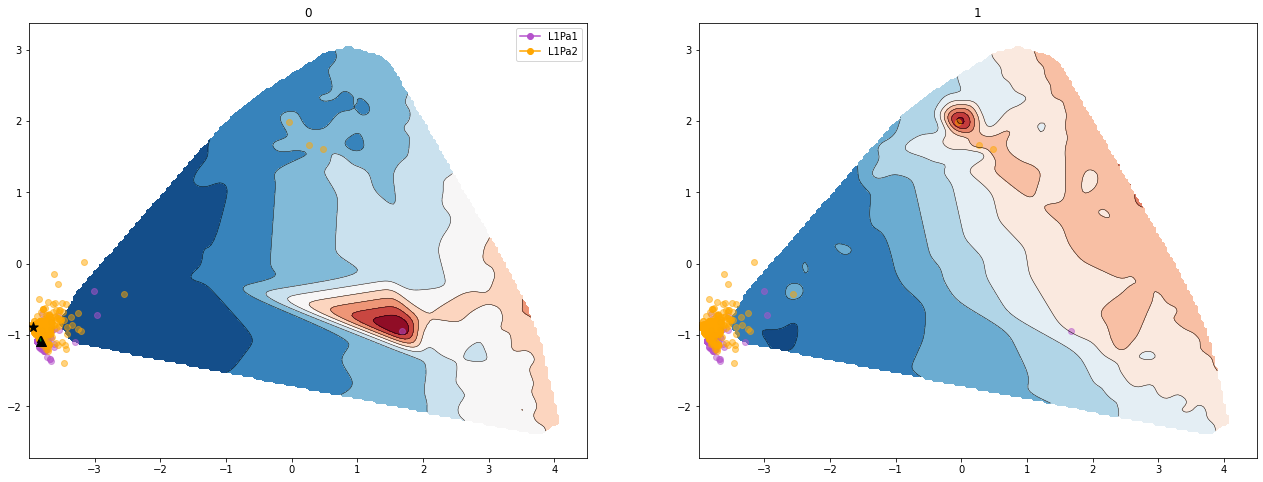

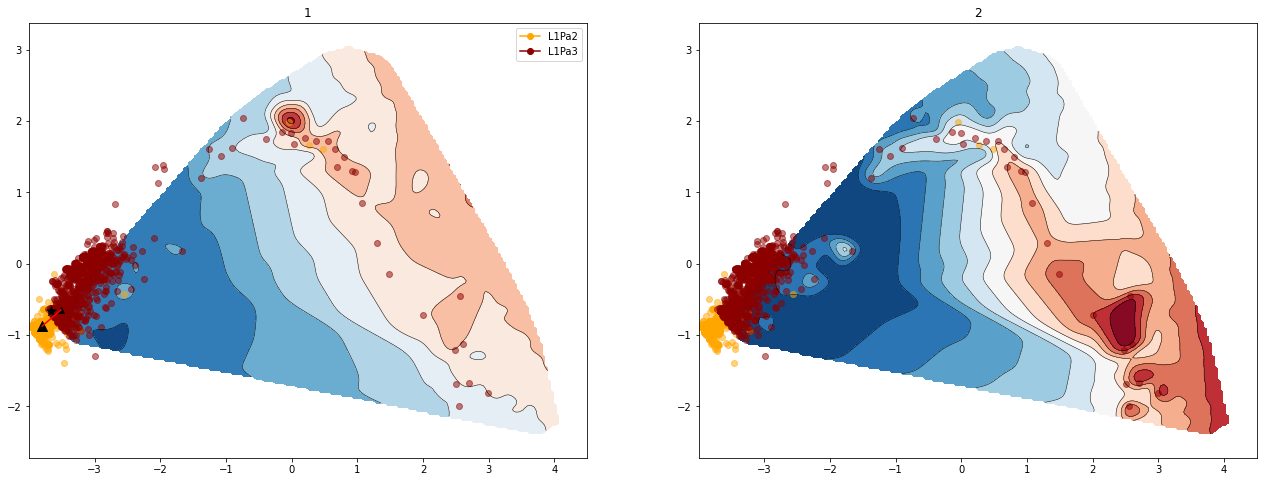

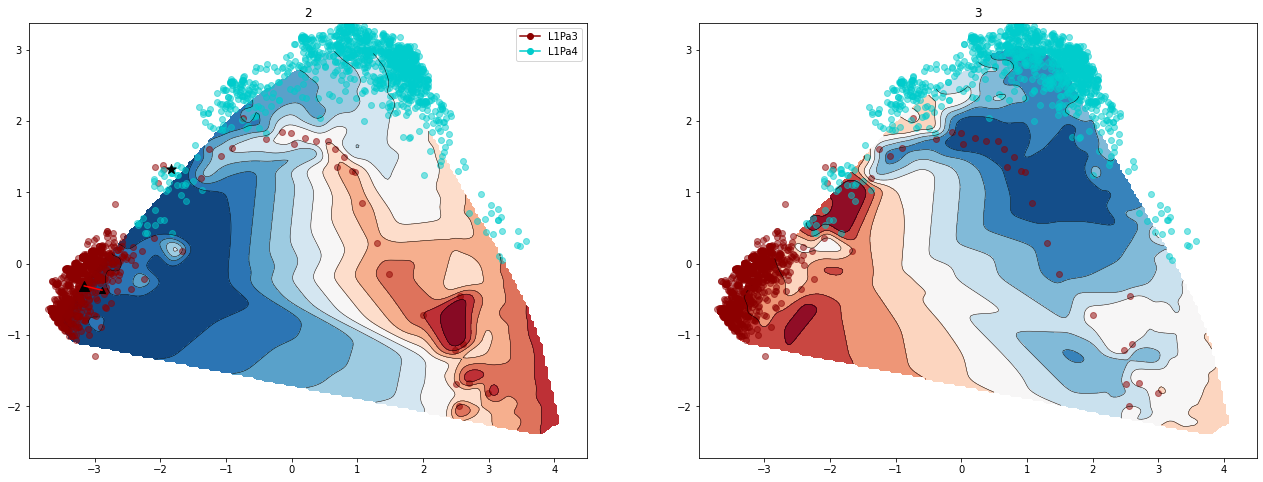

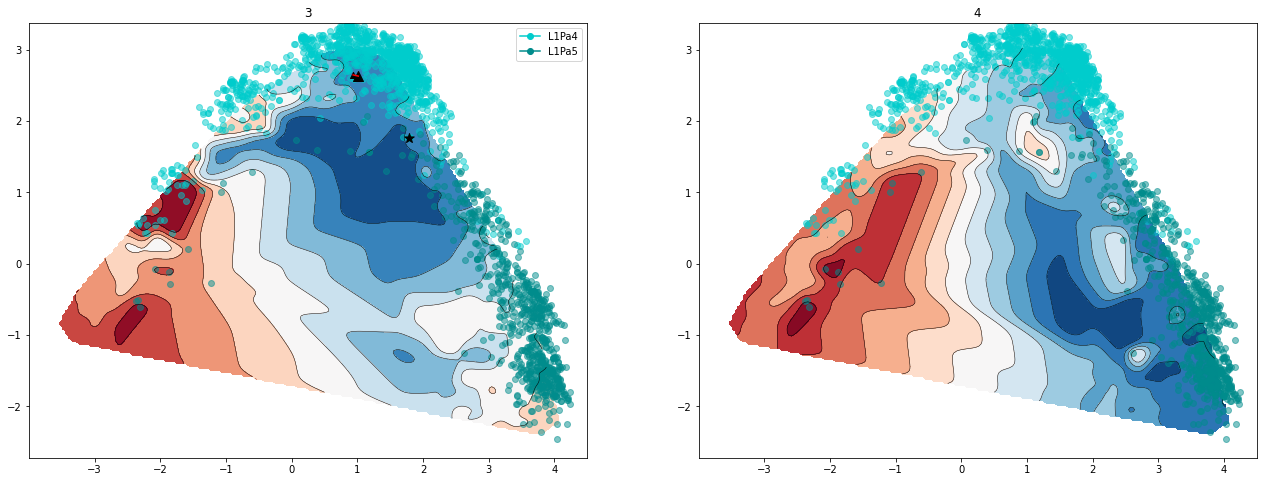

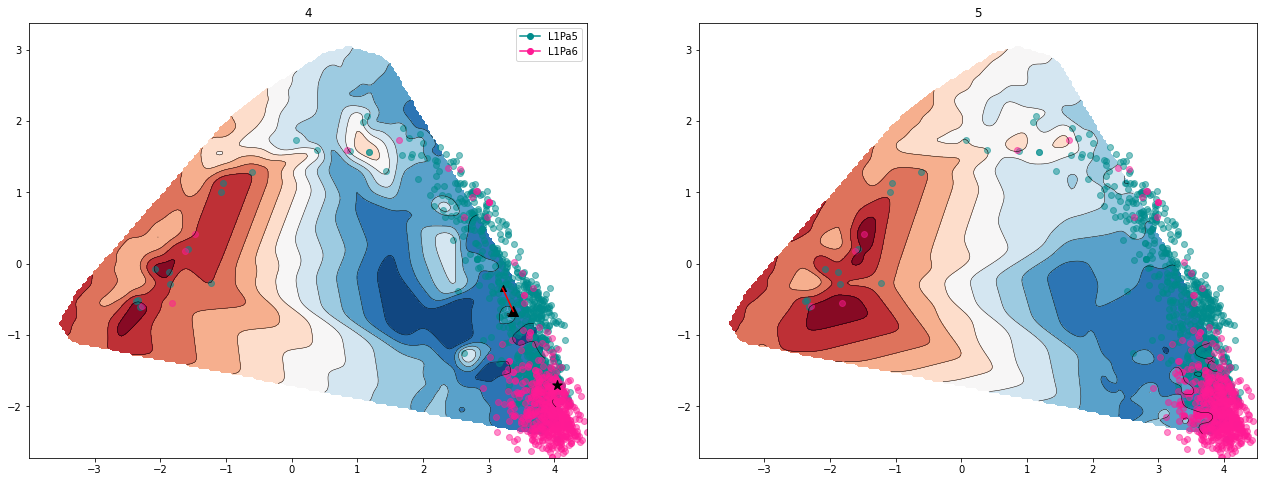

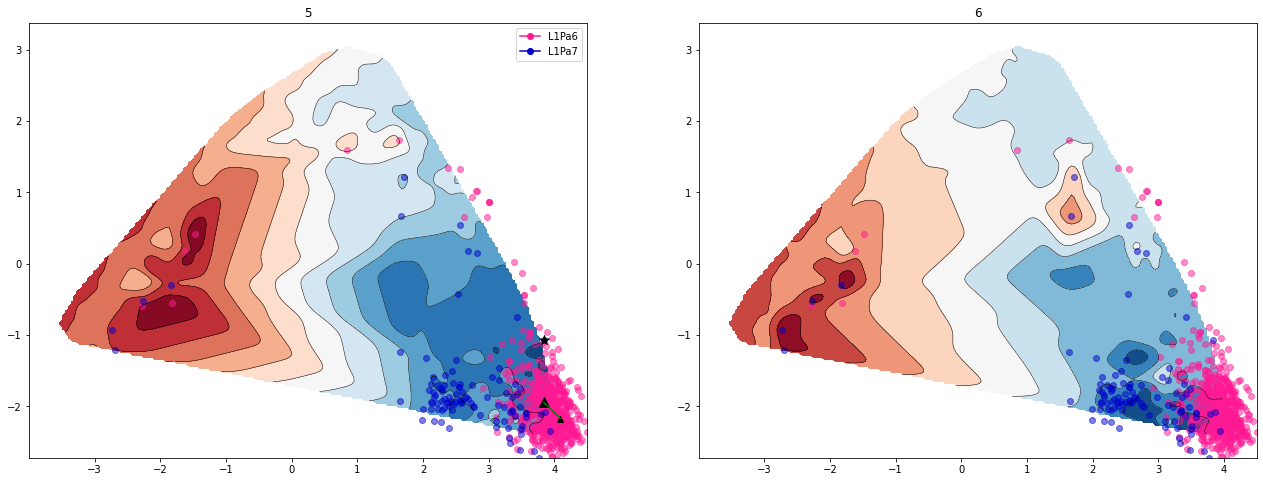

In [50]:
for i in range(len(w_families)):
    print(s_E_rows[i][:5])

for i in range(len(w_families)-1):
    fig = plt.figure(figsize=(22,8))
    ax1  = fig.add_subplot(121)    
    ax2  = fig.add_subplot(122)    
    print(i)
    msa_1 = i
    msa_2 =msa_1+1

    # get sequence count to sample
    gp1_indx = random_family_indx[msa_1]
    gp2_indx = random_family_indx[msa_2]


    
    gp1_mean = np.mean(s[gp1_indx],axis=0)
    gp2_mean = np.mean(s[gp2_indx],axis=0)
    w_gp1 = w_families[msa_1]
    w_gp2 = w_families[msa_2]
    
    print(np.concatenate((gp1_indx,gp2_indx)).shape)
    indx_12 = np.concatenate((gp1_indx,gp2_indx))
    s_12 = s[indx_12]
    pca = PCA(n_components=2).fit(s)                                                                   
    pca_s = pca.transform(s)
    gp1_mean_pca = pca.transform([gp1_mean])[0]


    z1 = s_E_rows[msa_1]
    z2 = s_E_rows[msa_2]

    print('%d energy: ' % msa_1, z1)
    print('%d energy: ' % msa_2, z2)
    try:

        x = full_s_pca[:,0]
        y = full_s_pca[:,1]
        print('x', x.shape)
        print('y', y.shape)

        n_levels=10
        sigma = .001
        # Create grid values first.
        ngridx = 200
        ngridy = 200
        xi = np.linspace(min(x), max(x), ngridx)
        yi = np.linspace(min(y), max(y), ngridy)

        # Perform linear interpolation of the data (x,y)
        # on a grid defined by (xi,yi)
        triang = tri.Triangulation(x, y)

        interpolator1 = tri.LinearTriInterpolator(triang, z1)
        interpolator2 = tri.LinearTriInterpolator(triang, z2)

        # interpolator = tri.CubicTriInterpolator(triang, z)

        Xi, Yi = np.meshgrid(xi, yi)

        zi1 = interpolator1(Xi, Yi)
        Zi1 = gaussian_filter(zi1, sigma=2.)

        zi2 = interpolator2(Xi, Yi)
        Zi2 = gaussian_filter(zi2, sigma=2.) 
    except(ValueError): # do not have scores for non-evo x,y longer because we have pca for non-evo
        x = s_pca[:,0]
        y = s_pca[:,1]
        print('x', x.shape)
        print('y', y.shape)

        n_levels=10
        sigma = .001
        # Create grid values first.
        ngridx = 200
        ngridy = 200
        xi = np.linspace(min(x), max(x), ngridx)
        yi = np.linspace(min(y), max(y), ngridy)

        # Perform linear interpolation of the data (x,y)
        # on a grid defined by (xi,yi)
        triang = tri.Triangulation(x, y)

        interpolator1 = tri.LinearTriInterpolator(triang, z1)
        interpolator2 = tri.LinearTriInterpolator(triang, z2)

        # interpolator = tri.CubicTriInterpolator(triang, z)

        Xi, Yi = np.meshgrid(xi, yi)

        zi1 = interpolator1(Xi, Yi)
        Zi1 = gaussian_filter(zi1, sigma=2.)

        zi2 = interpolator2(Xi, Yi)
        Zi2 = gaussian_filter(zi2, sigma=2.)         
    
    
    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    ax1.contour(Xi, Yi, Zi1, levels=10, linewidths=0.5, colors='k')
    cntr11 = ax1.contourf(Xi, Yi, Zi1, levels=10, cmap="RdBu_r")
    ax2.contour(Xi, Yi, Zi2, levels=10, linewidths=0.5, colors='k')
    cntr12 = ax2.contourf(Xi, Yi, Zi2, levels=10, cmap="RdBu_r")   

    # plot the sequence points for both families
#     ax1.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1],alpha=.5)  
#     ax1.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2],alpha=.5)                                                                               
#     ax2.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1],alpha=.5)  
#     ax2.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2],alpha=.5)                                                                               
    ax1.scatter(pca_s[gp1_indx,0], pca_s[gp1_indx,1], color=colors[msa_1],alpha=.5)  
    ax1.scatter(pca_s[gp2_indx,0], pca_s[gp2_indx,1], color=colors[msa_2],alpha=.5)                                                                               
    ax2.scatter(pca_s[gp1_indx,0], pca_s[gp1_indx,1], color=colors[msa_1],alpha=.5)  
    ax2.scatter(pca_s[gp2_indx,0], pca_s[gp2_indx,1], color=colors[msa_2],alpha=.5)                                                                               

    
    # plot the mean value perturbed and the boundary sequence of the descendant
    # fin closest descendant
    min_dist = 100000.
    for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
        pt_dist = pdist((gp1_mean,msa2_seq))
        if pt_dist < min_dist:
            min_dist = pt_dist
            min_id = ii
    boundary_seq = s[family_indx[msa_2]][min_id]
    boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]
    
    wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
    pca_wER_pert = pca.transform(wER_pert)

    cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
    if cos_theta > 0.:        
        ax1.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='g')
    else:
        ax1.plot(pca_wER_pert[:,0], pca_wER_pert[:,1], color='r')
    ax1.scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
    ax1.scatter(gp1_mean_pca[0], gp1_mean_pca[1], marker='^',color='k',s=100)
    ax1.scatter(boundary_seq_pca[0], boundary_seq_pca[1], marker='*',color='k',s=100)


    ax1.legend(handles=legend_elements[i:i+2])
    ax1.set_title('%d'% msa_1)
    ax2.set_title('%d'% msa_2)

x (4341,)
y (4341,)
[-0.89179024 -0.6119022  -0.57219289 ...  1.51149352  1.94755591
  3.49594363]
x (4341,)
y (4341,)
[-0.89179024 -0.6119022  -0.57219289 ...  1.51149352  1.94755591
  3.49594363]
x (4341,)
y (4341,)
[-0.89179024 -0.6119022  -0.57219289 ...  1.51149352  1.94755591
  3.49594363]
x (4341,)
y (4341,)
[-1.96018488 -1.65774705 -1.41625101 ...  2.35718893  2.41907978
  4.53961225]
x (4341,)
y (4341,)
[-1.96018488 -1.65774705 -1.41625101 ...  2.35718893  2.41907978
  4.53961225]
x (4341,)
y (4341,)
[-1.96018488 -1.65774705 -1.41625101 ...  2.35718893  2.41907978
  4.53961225]
x (4341,)
y (4341,)
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]
x (4341,)
y (4341,)
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]
x (4341,)
y (4341,)
[-4.22170297 -3.99245608 -3.1875145  ...  4.2850354   5.790757
  6.60809002]
x (4341,)
y (4341,)
[-4.72490482 -4.35455391 -4.06111926 ...  5.34744509  6.09853272
  7.05570121]
x (4341,)
y (434

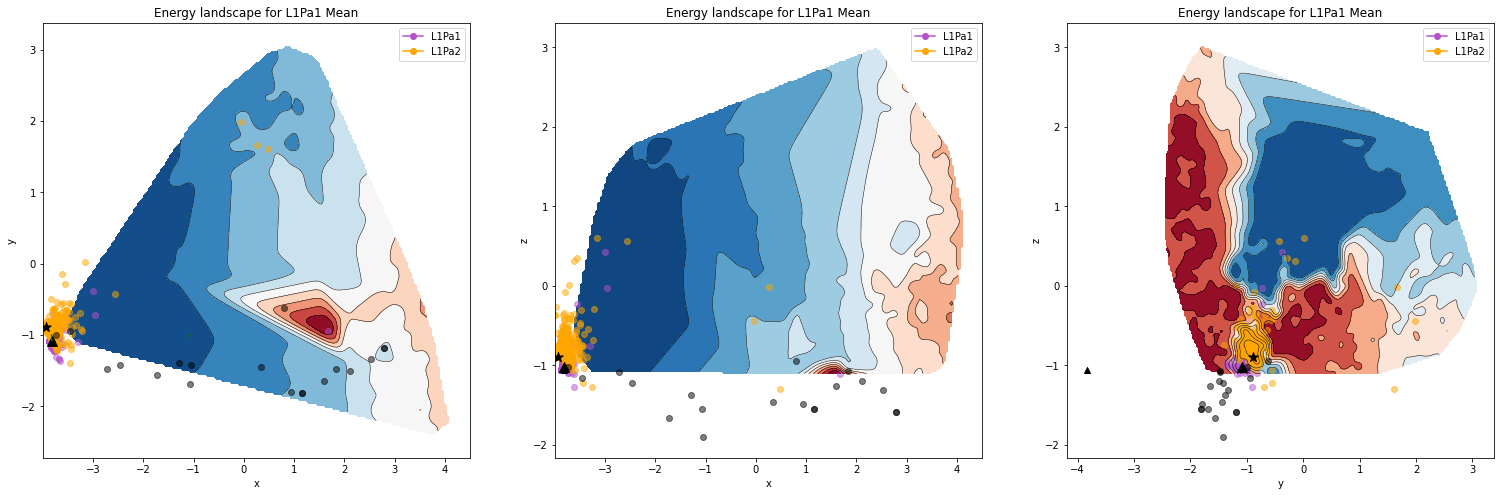

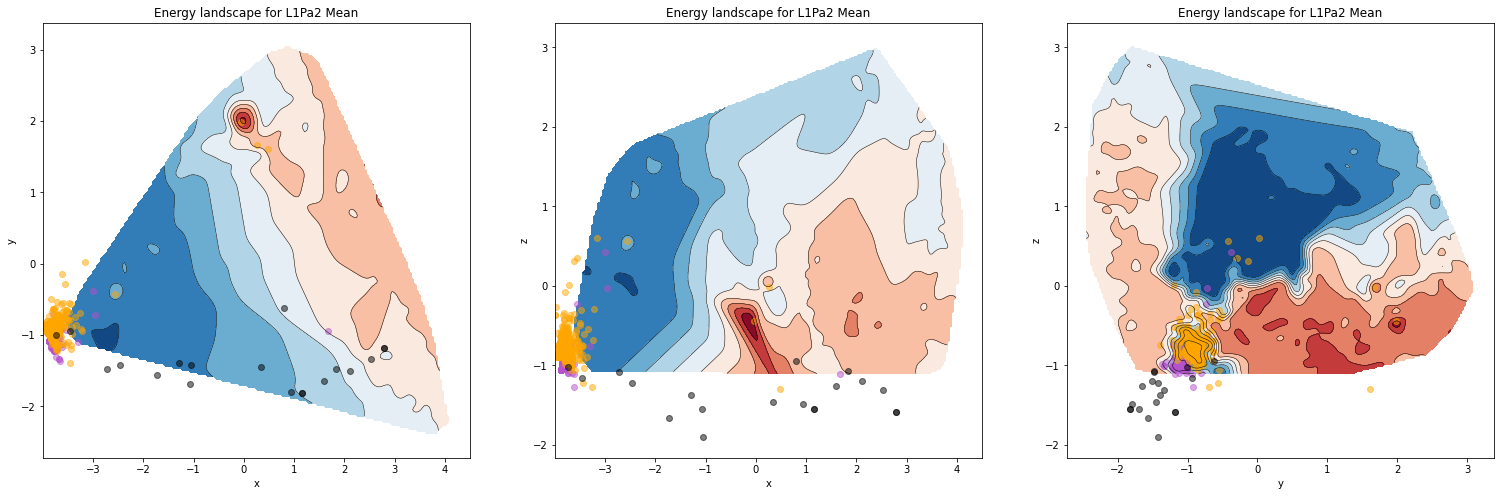

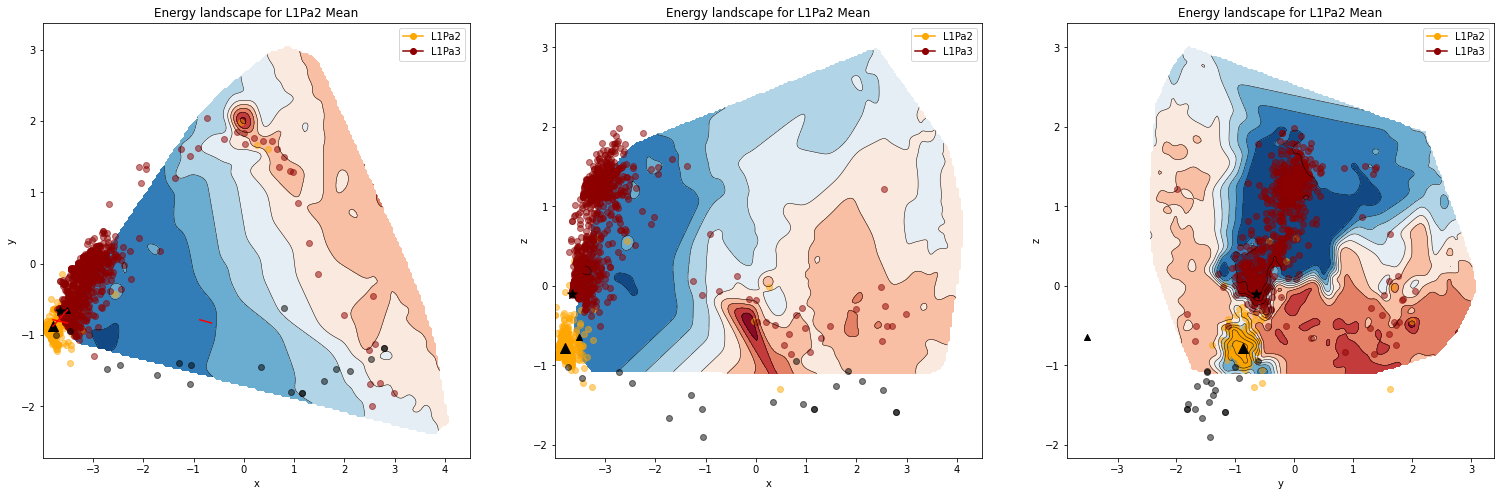

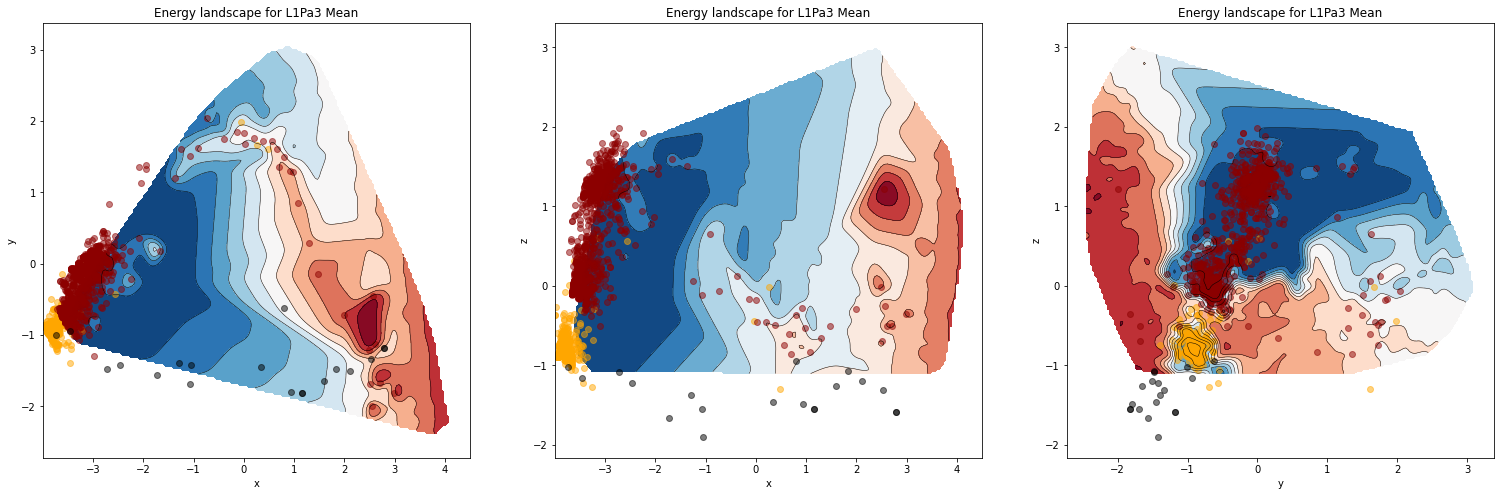

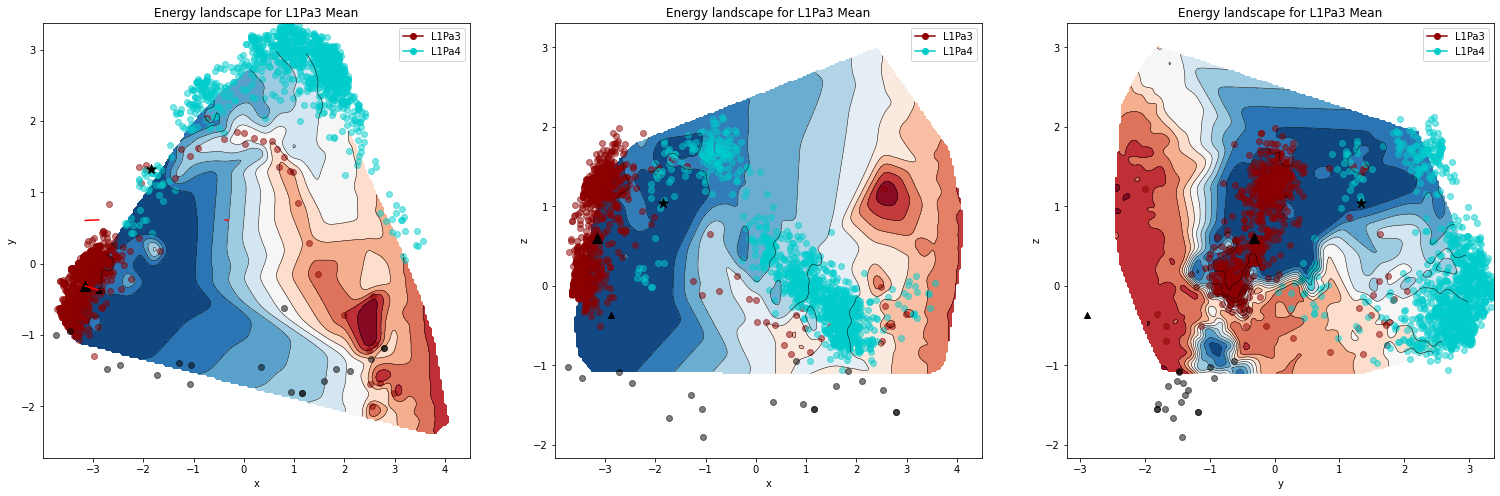

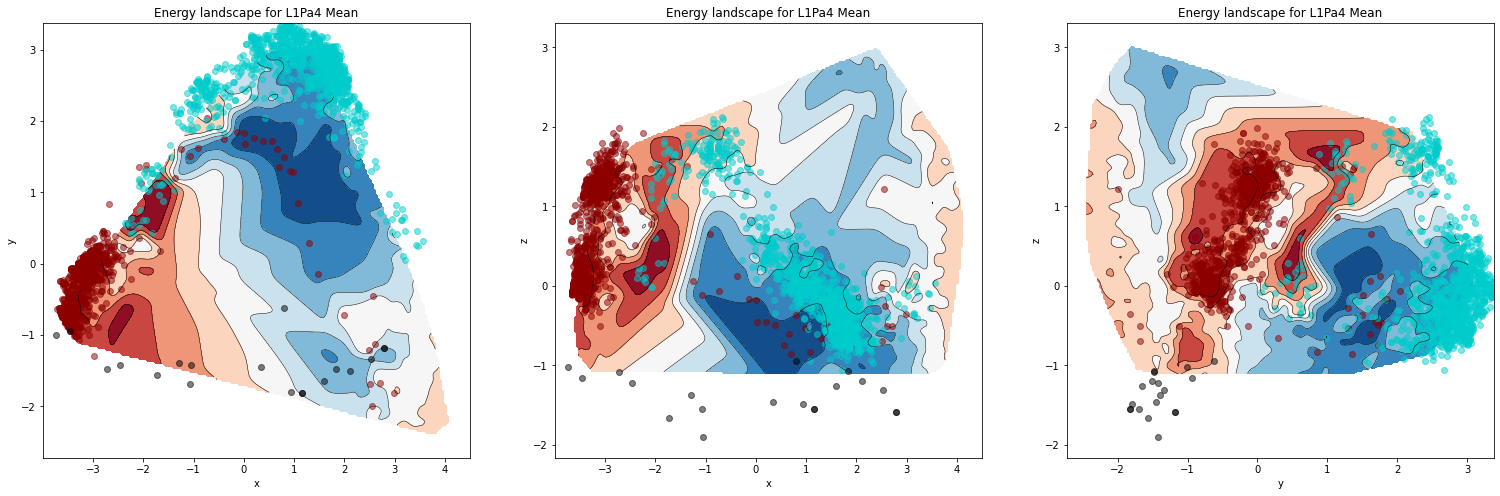

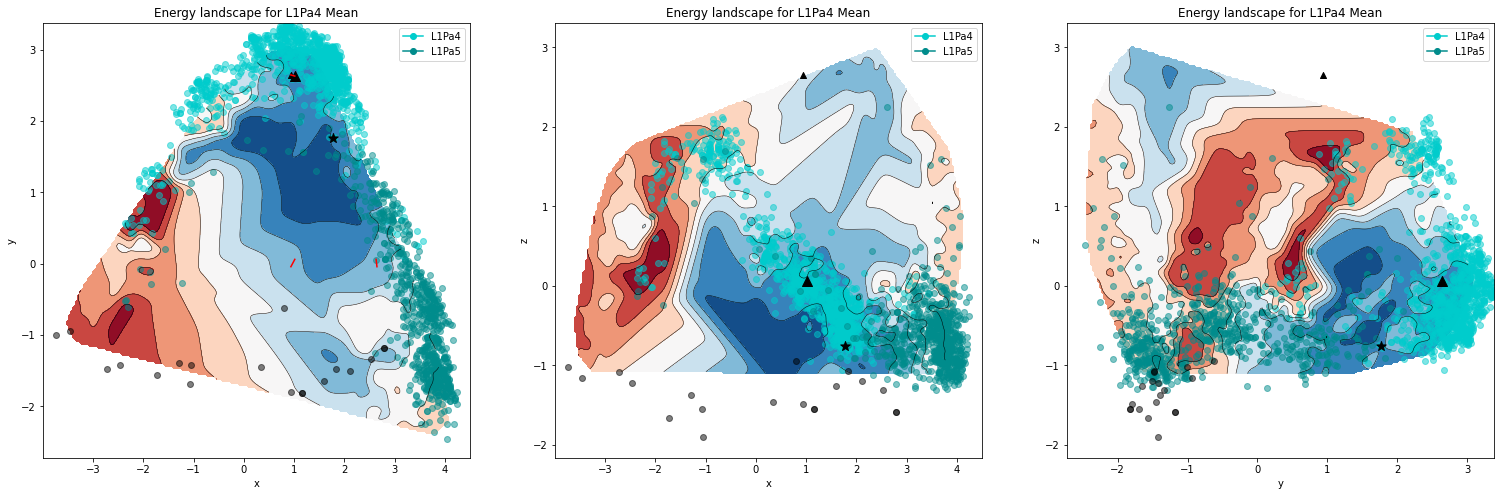

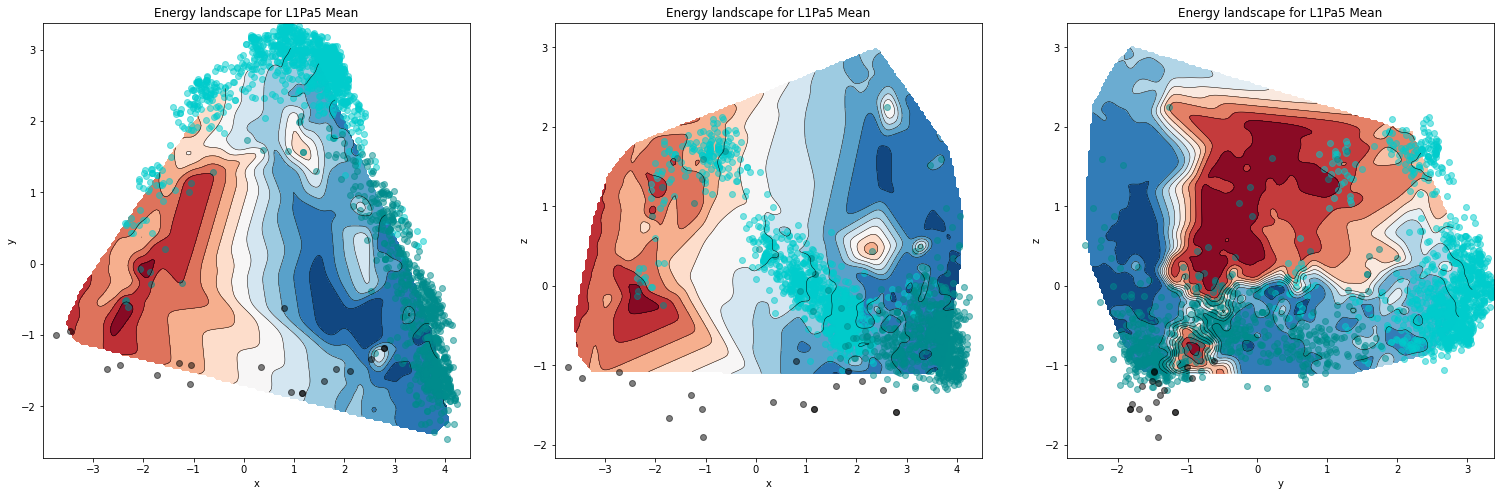

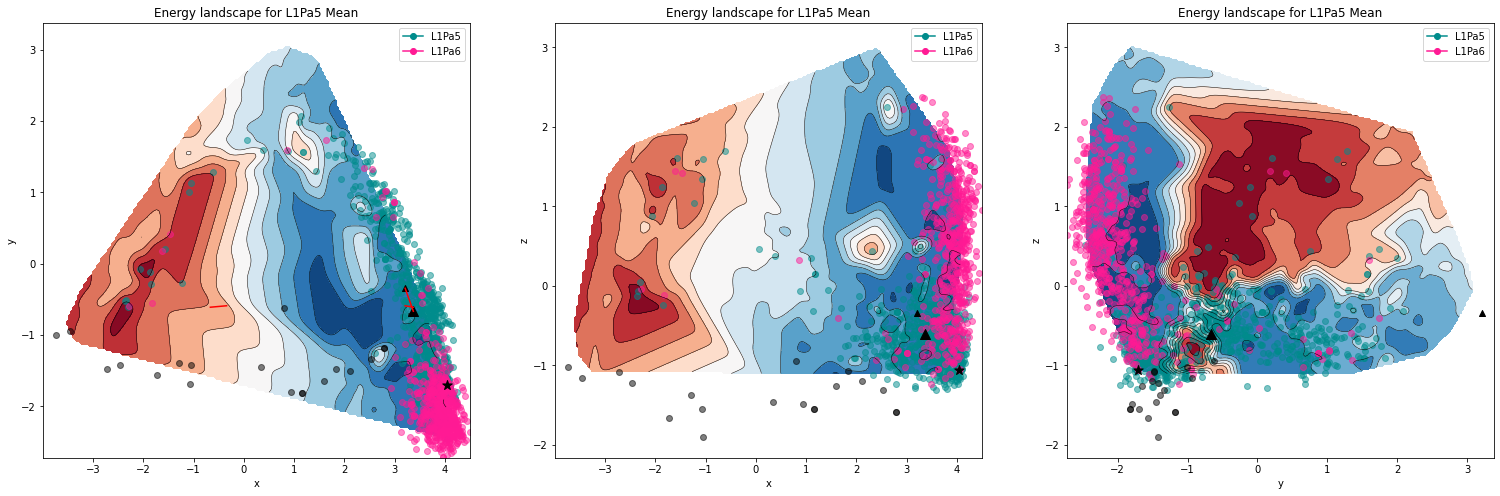

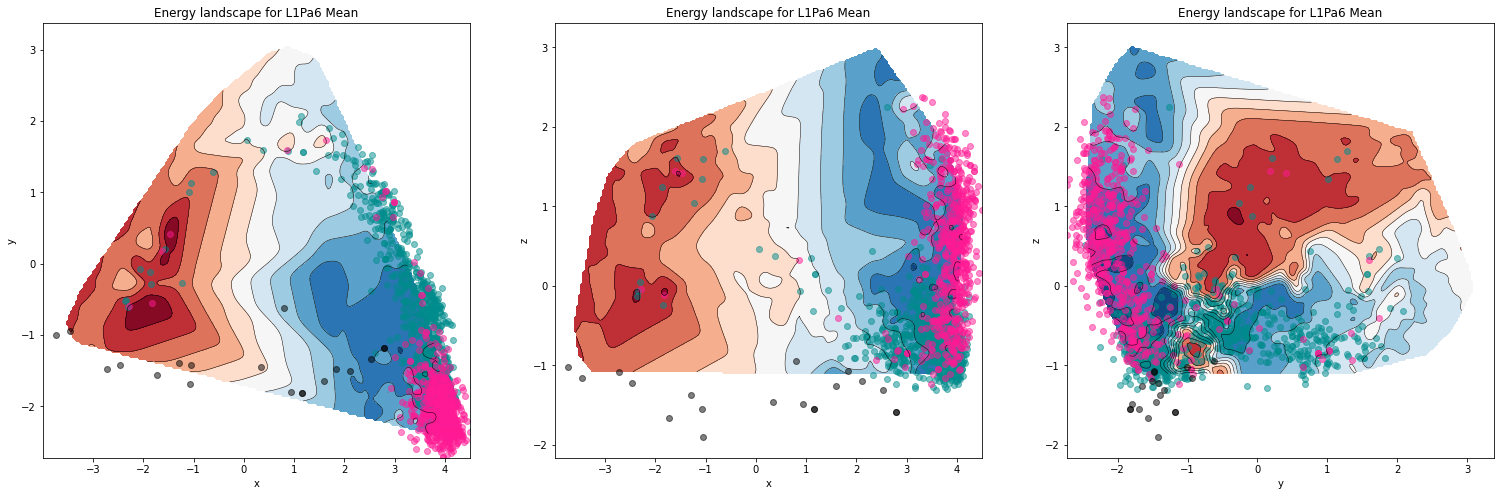

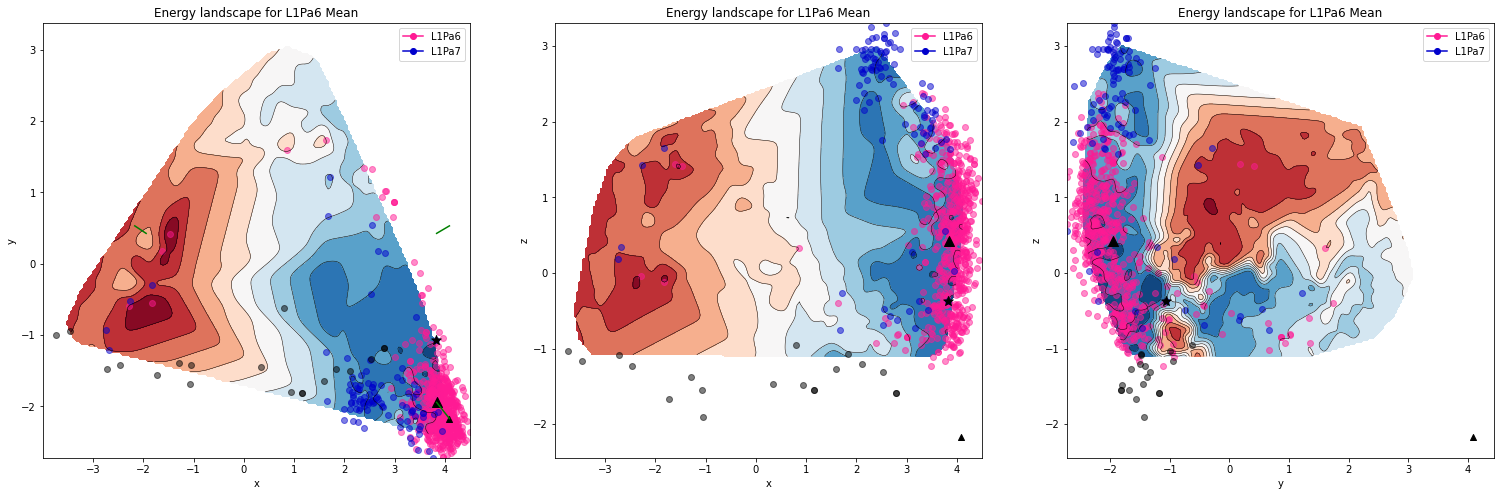

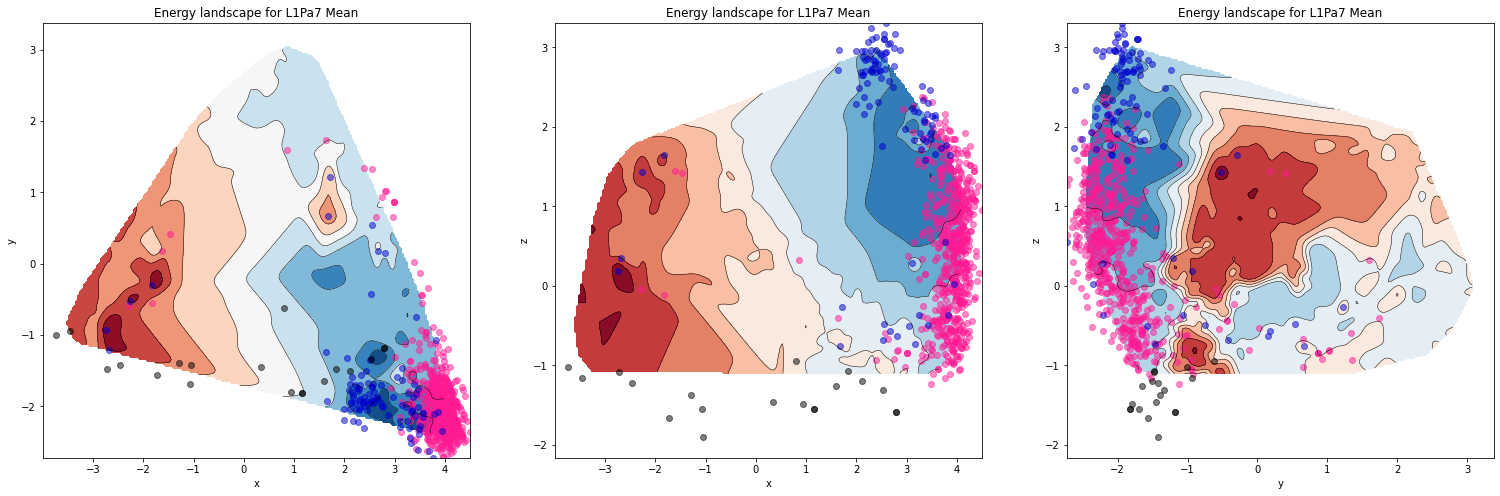

In [51]:
s0_len = len(s0)

# for i in range(len(w_families)):
#     print(s_E_rows[i][:5])

for i in range(len(w_families)-1):
    fig1 = plt.figure(figsize=(26,8))
    fig2 = plt.figure(figsize=(26,8))

    ax1  = fig1.add_subplot(131)    
    ax2  = fig1.add_subplot(132)    
    ax3  = fig1.add_subplot(133)    
    ax4  = fig2.add_subplot(131)    
    ax5  = fig2.add_subplot(132)    
    ax6  = fig2.add_subplot(133)    

    msa_1 = i
    msa_2 =msa_1+1

    # get sequence count to sample
    gp1_indx = random_family_indx[msa_1]
    gp2_indx = random_family_indx[msa_2]


    
    gp1_mean = np.mean(s[gp1_indx],axis=0)
    gp2_mean = np.mean(s[gp2_indx],axis=0)
    w_gp1 = w_families[msa_1]
    w_gp2 = w_families[msa_2]
    
#     print(np.concatenate((gp1_indx,gp2_indx)).shape)
    indx_12 = np.concatenate((gp1_indx,gp2_indx))
    s_12 = s[indx_12]
    pca = PCA(n_components=3).fit(s)                                                                   
    full_pca_s = pca.transform(full_s)
    pca_s = pca.transform(s)
    gp1_mean_pca = pca.transform([gp1_mean])[0]


    z1 = s_E_rows[msa_1]
    z2 = s_E_rows[msa_2]

#     print('%d energy: ' % msa_1, z1)
#     print('%d energy: ' % msa_2, z2)

    planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
    ax_labels = ['x', 'y' , 'z']
    axes1 = [ax1, ax2, ax3]  # panel 1 to plot the different planes for msa 1
    axes2 = [ax4, ax5, ax6]  # panel 2 to plot the different planes for msa 2

    for dim in range(3):
        try:
            x = full_pca_s[:,planes[dim][0]]
            y = full_pca_s[:,planes[dim][1]]
    #         print('x', x.shape)
    #         print('y', y.shape)

            n_levels=10
            sigma = .001
            # Create grid values first.
            ngridx = 200
            ngridy = 200
            xi = np.linspace(min(x), max(x), ngridx)
            yi = np.linspace(min(y), max(y), ngridy)


            # Perform linear interpolation of the data (x,y)
            # on a grid defined by (xi,yi)
            triang = tri.Triangulation(x, y)


            interpolator1 = tri.LinearTriInterpolator(triang, z1)
            interpolator2 = tri.LinearTriInterpolator(triang, z2)
        except(ValueError): # do not have scores for non-evo x,y longer because we have pca for non-evo
            x = pca_s[:,planes[dim][0]]
            y = pca_s[:,planes[dim][1]]
            print('x', x.shape)
            print('y', y.shape)

            n_levels=10
            sigma = .001
            # Create grid values first.
            ngridx = 200
            ngridy = 200
            xi = np.linspace(min(x), max(x), ngridx)
            yi = np.linspace(min(y), max(y), ngridy)

            # Perform linear interpolation of the data (x,y)
            # on a grid defined by (xi,yi)
            triang = tri.Triangulation(x, y)

            interpolator1 = tri.LinearTriInterpolator(triang, z1)
            interpolator2 = tri.LinearTriInterpolator(triang, z2)        # interpolator = tri.CubicTriInterpolator(triang, z)

        Xi, Yi = np.meshgrid(xi, yi)

        zi1 = interpolator1(Xi, Yi)
        Zi1 = gaussian_filter(zi1, sigma=2.)

        zi2 = interpolator2(Xi, Yi)
        Zi2 = gaussian_filter(zi2, sigma=2.)    

        # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
        # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
        axes1[dim].contour(Xi, Yi, Zi1, levels=10, linewidths=0.5, colors='k')
        cntr11 = axes1[dim].contourf(Xi, Yi, Zi1, levels=10, cmap="RdBu_r")
        axes2[dim].contour(Xi, Yi, Zi2, levels=10, linewidths=0.5, colors='k')
        cntr12 = axes2[dim].contourf(Xi, Yi, Zi2, levels=10, cmap="RdBu_r")   


        # plot the sequence points for both families
        axes1[dim].scatter(pca_s[gp1_indx,planes[dim][0]], pca_s[gp1_indx,planes[dim][1]], color=colors[msa_1],alpha=.5)  
        axes1[dim].scatter(pca_s[gp2_indx,planes[dim][0]], pca_s[gp2_indx,planes[dim][1]], color=colors[msa_2],alpha=.5)                                                                               
        axes1[dim].scatter(full_pca_s[s0_len:,planes[dim][0]], full_pca_s[s0_len:,planes[dim][1]], label='Outliers',color='k',alpha=.5,marker='o')

        
        axes2[dim].scatter(pca_s[gp1_indx,planes[dim][0]], pca_s[gp1_indx,planes[dim][1]], color=colors[msa_1],alpha=.5)  
        axes2[dim].scatter(pca_s[gp2_indx,planes[dim][0]], pca_s[gp2_indx,planes[dim][1]], color=colors[msa_2],alpha=.5)                                                                               
        axes2[dim].scatter(full_pca_s[s0_len:,planes[dim][0]], full_pca_s[s0_len:,planes[dim][1]], label='Outliers',c='k',alpha=.5,marker='o')                                                                               


        # plot the mean value perturbed and the boundary sequence of the descendant
        # fin closest descendant
        min_dist = 100000.
        for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
            pt_dist = pdist((gp1_mean,msa2_seq))
            if pt_dist < min_dist:
                min_dist = pt_dist
                min_id = ii
        boundary_seq = s[family_indx[msa_2]][min_id]
        boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]

        wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
        pca_wER_pert = pca.transform(wER_pert)

        cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
        if cos_theta > 0.:        
            ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='g')
        else:
            ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='r')
        axes1[dim].scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
        axes1[dim].scatter(gp1_mean_pca[planes[dim][0]], gp1_mean_pca[planes[dim][1]], marker='^',color='k',s=100)
        axes1[dim].scatter(boundary_seq_pca[planes[dim][0]], boundary_seq_pca[planes[dim][1]], marker='*',color='k',s=100)


        axes1[dim].legend(handles=legend_elements[i:i+2])
        axes1[dim].set_title('Energy landscape for %s Mean'% lp_names[msa_1])
        axes2[dim].set_title('Energy landscape for %s Mean'% lp_names[msa_2])
        axes1[dim].set_xlabel(ax_labels[planes[dim][0]])
        axes1[dim].set_ylabel(ax_labels[planes[dim][1]])
        axes2[dim].set_xlabel(ax_labels[planes[dim][0]])
        axes2[dim].set_ylabel(ax_labels[planes[dim][1]])
        
        

0 1
(4360, 3)
4341


ValueError: 'c' argument has 4341 elements, which is inconsistent with 'x' and 'y' with size 4360.

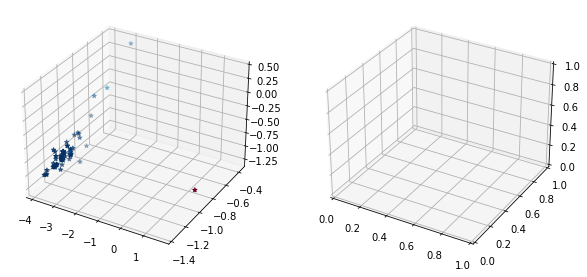

In [52]:
for i in range(len(w_families)-1):
    fig = plt.figure(figsize=(10,5))
    ax1  = fig.add_subplot(121, projection='3d')    
    ax2  = fig.add_subplot(122, projection='3d')    
    print(i, i+1)
    msa_1 = i
    msa_2 =msa_1+1

    # get sequence count to sample
    gp1_indx = random_family_indx[msa_1]
    gp2_indx = random_family_indx[msa_2]
    
    gp1_mean = np.mean(s[gp1_indx],axis=0)
    gp2_mean = np.mean(s[gp2_indx],axis=0)
    w_gp1 = w_families[msa_1]
    w_gp2 = w_families[msa_2]
    
    indx_12 = np.concatenate((gp1_indx,gp2_indx))
    s_12 = s[indx_12]
    pca = PCA(n_components=3).fit(s)                                                                   
    full_pca_s = pca.transform(full_s)

    z1 = s_E_rows[msa_1]
    z2 = s_E_rows[msa_2]
    energy_colors1 = z1 / max(z1)
    energy_colors2 = z2 / max(z2)

    # plot the sequence points for both families
#     ax1.scatter(pca_s[gp1_indx,0], pca_s[gp1_indx,1], pca_s[gp1_indx,2], c=z1[gp1_indx],cmap="RdBu_r" , alpha=.1)  
#     ax1.scatter(pca_s[gp2_indx,0], pca_s[gp2_indx,1], pca_s[gp2_indx,2], c=z1[gp2_indx],cmap="RdBu_r" , alpha=.1)  
#     ax2.scatter(pca_s[gp1_indx,0], pca_s[gp1_indx,1], pca_s[gp1_indx,2], c=z2[gp1_indx],cmap="RdBu_r" , alpha=.1)  
#     ax2.scatter(pca_s[gp2_indx,0], pca_s[gp2_indx,1], pca_s[gp2_indx,2], c=z2[gp2_indx],cmap="RdBu_r" , alpha=.1)  
    print(full_pca_s.shape)
    print(len(z1))
    ax1.scatter(full_pca_s[gp1_indx,0], full_pca_s[gp1_indx,1], full_pca_s[gp1_indx,2], c=z1[gp1_indx],cmap="RdBu_r",marker='*' )  
    ax1.scatter(full_pca_s[:,0], full_pca_s[:,1], full_pca_s[:,2], c=z1,cmap="RdBu_r" , alpha=.05)  
    ax1.scatter(full_pca_s[s0_len:,0], full_pca_s[s0_len:,1], full_pca_s[s0_len:,2], c=z1[s0_len:],cmap="RdBu_r" ,marker='o',s=100)  

    ax2.scatter(full_pca_s[gp2_indx,0], full_pca_s[gp2_indx,1], full_pca_s[gp2_indx,2], c=z2[gp2_indx],cmap="RdBu_r",marker='*' )  
    ax2.scatter(full_pca_s[:,0], full_pca_s[:,1], full_pca_s[:,2], c=z2,cmap="RdBu_r" , alpha=.05)  
#     ax2)scatter(full_pca_s[s0_len:,0], full_pca_s[s0_len:,1], full_pca_s[s0_len:,2], c=z2[gp2_indx:],cmap="RdBu_r",marker='o',s=100)  

    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')

                                                                               
    plt.show()

In [ ]:
## Transition Sequence AA identification

In [ ]:
# get sequences in region of line between means of two groups


msa_1 = 1
msa_2 =msa_1+1

# get sequence count to sample
sample_size = min(len(family_indx[msa_1]), len(family_indx[msa_2]))
gp1_indx = random_family_indx[msa_1][:sample_size]
gp2_indx = random_family_indx[msa_2][:sample_size]



gp1_mean = np.mean(s[gp1_indx],axis=0)
gp2_mean = np.mean(s[gp2_indx],axis=0)


w_gp1 = w_families[msa_1]
w_gp2 = w_families[msa_2]

print(np.concatenate((gp1_indx,gp2_indx)).shape)
indx_12 = np.concatenate((gp1_indx,gp2_indx))
indx_12_full = np.concatenate((family_indx[msa_1],family_indx[msa_2]))
s_12 = s[indx_12]
pca = PCA(n_components=3).fit(s)                                                                   
pca_s = pca.transform(s)
gp1_mean_pca = pca.transform([gp1_mean])[0]
gp2_mean_pca = pca.transform([gp2_mean])[0]

z1 = s_E_rows[msa_1]

x = full_pca_s[:,1]
y = full_pca_s[:,2]

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)

# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)

interpolator1 = tri.LinearTriInterpolator(triang, z1)

# interpolator = tri.CubicTriInterpolator(triang, z)

Xi, Yi = np.meshgrid(xi, yi)

zi1 = interpolator1(Xi, Yi)
Zi1 = gaussian_filter(zi1, sigma=2.)



# plot the mean value perturbed and the boundary sequence of the descendant
# fin closest descendant
min_dist = 100000.
for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
    pt_dist = pdist((gp1_mean,msa2_seq))
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = ii
boundary_seq = s[family_indx[msa_2]][min_id]
boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]

wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
pca_wER_pert = pca.transform(wER_pert)

cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)

In [ ]:
transition_line_function = lambda p: gp1_mean + p * (boundary_seq- gp1_mean)

passage_seq_energy = []
passage_sequences = []

for i in range (100):
    path_frac = (100.-i)/100. 
    path_seq = transition_line_function(path_frac)
    passage_sequences.append(path_seq)
    passage_seq_energy.append(energy_diff(i1i2,gp1_mean,path_seq,w_gp1))
passage_seqs_pca = pca.transform(passage_sequences)

closest_passage_seq_indx = []
closest_passage_seqs = []
closest_seq_energy = []
for i in range(100):
    path_seq_pca = passage_seqs_pca[i]
    min_dist = 1000000
    min_indx=-1
#     for ii in range(len(pca_s)):
#     for ii, seqq in enumerate(pca_s[indx_12_full]):
#         iii = indx_12_full[ii]
    for ii, seqq in enumerate(pca_s):
        iii = ii # dont need index mapping since we're going through entire set
        pt_dist = pdist((path_seq_pca, seqq))
#         if pt_dist[0] < min_dist and iii not in closest_passage_seq_indx:
        if pt_dist[0] < min_dist:
            min_dist = pt_dist[0]
            min_indx = iii
    closest_passage_seq_indx.append(min_indx)
    closest_seq_energy.append(energy_diff(i1i2,gp1_mean,s[min_indx],w_gp1))
    closest_passage_seqs.append(pca_s[min_indx])
# print(np.array(closest_passage_seqs)   )

In [ ]:
# find "sequences" in low eigenvalue direction
if 1: 
    pert_mags = np.linspace(-10,10, num=20)
    print(pert_mags)
    passage_ref_seqs = s[closest_passage_seq_indx,:]
    print(passage_ref_seqs)

    w, v  = np.linalg.eigh(w_gp1)
    print('w first 10 ', w[:10])
    print('w last 10 ', w[-10:])
    move_dim = 0
    print('move-dim eigenvalue: ', w[move_dim])
    passage_ridge_seqs = []
    passage_ridge_aa = []
    found_imaginary = False
    for ref_seq in passage_ref_seqs:
        trans_seq_full_mag = []
        passage_ridge_seqs.append([])
        passage_ridge_aa.append([])
        for i,mag in enumerate(pert_mags):    
            trans_seq_full_out = ER_perturb(ref_seq, w, v, pert_mag=mag, pert_dir=move_dim)
            real_seq = []
#             print(trans_seq_full_out)
            for ii,val in enumerate(trans_seq_full_out):
                    if val.imag < 1e-8: # equivalent to float32 precision..
                    # https://stackoverflow.com/questions/8765310/scipy-linalg-eig-return-complex-eigenvalues-for-covariance-matrix
                        real_seq.append( float(val.real))
#                         print(val)
#                         print(val.imag)
#                         print(val.real)
                        found_imaginary = True
                    else:
                        print('large complex')
                        print(val)
                        sys.exit()
            real_seq = np.array(real_seq)
#             print(real_seq.shape)

            trans_seqs_aa = onehot_encoder.inverse_transform([real_seq])[0]

#             trans_seq_full_out = 
            passage_ridge_seqs[-1].append(real_seq)
            passage_ridge_aa[-1].append(trans_seqs_aa)

print('\n\n Passage-Ridge Sequences (imaginary filtered out)')
print(passage_ridge_seqs[0][0])
print(passage_ridge_aa[0][0])
passage_ridge_pca = []
for sequence_group in passage_ridge_seqs:
    passage_ridge_pca.append(pca.transform(sequence_group))
passage_ridge_pca = np.array(passage_ridge_pca)
print(passage_ridge_pca.shape)
if found_imaginary:
    print('imaginary values generated in ER perturbation')

In [ ]:
fig = plt.figure(figsize=(11,8))
ax1  = fig.add_subplot(111)    

# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
ax1.contour(Xi, Yi, Zi1, levels=10, linewidths=0.5, colors='k',alpha = .3)
cntr11 = ax1.contourf(Xi, Yi, Zi1, levels=10, cmap="RdBu_r")  

# plot the sequence points for both families                                                                           
ax1.scatter(pca_s[gp1_indx,1], pca_s[gp1_indx,2], color=colors[msa_1],alpha=.5)  
ax1.scatter(pca_s[gp2_indx,1], pca_s[gp2_indx,2], color=colors[msa_2],alpha=.5)                                                                               


if cos_theta > 0.:        
    ax1.plot(pca_wER_pert[:,1], pca_wER_pert[:,2], color='g')
else:
    ax1.plot(pca_wER_pert[:,1], pca_wER_pert[:,2], color='r')
ax1.scatter(pca_wER_pert[-1,1], pca_wER_pert[-1,2],marker='^',color='k')
ax1.scatter(gp1_mean_pca[1], gp1_mean_pca[2], marker='^',color='k',s=200)
ax1.scatter(gp2_mean_pca[1], gp2_mean_pca[2], marker='^',color='k',s=200)

ax1.scatter(boundary_seq_pca[1], boundary_seq_pca[2], marker='*',color='k',s=200)


ax1.legend(handles=legend_elements[msa_1:msa_2+1], fontsize=14)


closest_passage_seqs = pca_s[closest_passage_seq_indx]
ax1.scatter(passage_seqs_pca[:,1], passage_seqs_pca[:,2], c='k')  
ax1.scatter(np.array(closest_passage_seqs)[0,1], np.array(closest_passage_seqs)[0,2], c='g',marker='*')  
ax1.scatter(np.array(closest_passage_seqs)[50,1], np.array(closest_passage_seqs)[50,2], c='g',marker='*')  
ax1.scatter(np.array(closest_passage_seqs)[-1,1], np.array(closest_passage_seqs)[-1,2], c='g',marker='*')  

ax1.scatter(passage_ridge_pca[0,:,1], passage_ridge_pca[0,:,2], c='b',marker='3')  
ax1.scatter(passage_ridge_pca[50,:,1], passage_ridge_pca[50,:,2], c='b',marker='3')  
ax1.scatter(passage_ridge_pca[-1,:,1], passage_ridge_pca[-1,:,2], c='b',marker='3')  

plt.ylabel('PCA 2', fontsize = 18)
plt.xlabel('PCA 1', fontsize = 18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
# plt.colorbar()
plt.savefig('L1_fitness.pdf')
plt.show()

In [ ]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
# get msa of passage sequences
# create MSA of omicron and delta variants
# valley_path_seqs = []
# for i, seq in enumerate(all_seqs):
#     if i in closest_passage_seq_indx:
#         valley_path_seqs.append(seq)
print(closest_passage_seq_indx)
valley_path_seqs = [seq for i,seq in enumerate(all_seqs) if i in closest_passage_seq_indx]
valley_path_alignment = MultipleSeqAlignment(valley_path_seqs)
output_handle = open("valley_path_seqs.fasta", "w")
AlignIO.write(valley_path_alignment, output_handle, "fasta")
output_handle.close()
import stat
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
submission_handle1 = open('rosettafold/vp_perp_part1.sh', "w")
submission_handle2 = open('rosettafold/vp_perp_part2.sh', "w")
submission_handle1.write('#!/bin/bash\n\n')
submission_handle2.write('#!/bin/bash\n\n')

for i, record in enumerate(valley_path_seqs):
    submission_handle1.write('sbatch --cpus-per-task=10 --mem=60G --time=1-00:00:00 --partition=norm vp%d_perp_part1.sh\n' % i)
    submission_handle2.write('sbatch --dependency=afterok:jobid --cpus-per-task=2 --mem=10g --partition=gpu --gres=gpu:v100x:1 vp%d_perp_part2.sh\n' % i)

    if not os.path.exists("rosettafold/vp%d_perp" % i):
        os.makedirs("rosettafold/vp%d_perp" % i)
    sim1_file_handle = open("rosettafold/vp%d_perp_part1.sh" % i, "w")
    sim2_file_handle = open("rosettafold/vp%d_perp_part2.sh" % i, "w")
    sim1_file_handle.write('#!/bin/bash\n\nmodule load RoseTTAFold\n')
    sim2_file_handle.write('#!/bin/bash\n\nmodule load RoseTTAFold\n')

    for j, perp_array in enumerate(passage_ridge_aa[i]):
        perp_record = SeqRecord(Seq(''.join(perp_array)), id="%s_perp%d" % (record.id,j))
        perp_record.seq = perp_record.seq.ungap("-")

        output_handle = open("rosettafold/vp%d_perp/perp%d.fasta" % (i,j), "w")
        SeqIO.write(perp_record, output_handle, "fasta")
        output_handle.close()
        sim1_file_handle.write('run_e2e_ver_part1.sh rosettafold/vp%d_perp/perp%d.fasta e2e_out_vp%d_p%d\n' % (i,j,i,j))
        sim2_file_handle.write('run_e2e_ver_part2.sh rosettafold/vp%d_perp/perp%d.fasta e2e_out_vp%d_p%d\n' % (i,j,i,j))

    
    sim1_file_handle.write('\n\n')
    sim1_file_handle.write('\n\n')
    for j, perp_array in enumerate(passage_ridge_aa[i]):
        sim1_file_handle.write('run_pyrosetta_ver_part1.sh rosettafold/vp%d_perp/perp%d.fasta pyrosetta_out_vp%d_p%d\n' % (i,j,i,j))
        sim2_file_handle.write('run_pyrosetta_ver_part2.sh rosettafold/vp%d_perp/perp%d.fasta pyrosetta_out_vp%d_p%d\n' % (i,j,i,j))

    sim1_file_handle.close()
    sim2_file_handle.close()
    # make executable -- unecessary
#     st = os.stat('vp%d_perp_part1.sh' % i)
#     os.chmod('vp%d_perp_part1.sh' % i, st.st_mode | stat.S_IEXEC)
#     st = os.stat('vp%d_perp_part2.sh' % i)
#     os.chmod('vp%d_perp_part2.sh' % i, st.st_mode | stat.S_IEXEC)
submission_handle1.close()
submission_handle2.close()

In [ ]:

fig = plt.figure()
# plt.plot(passage_seq_energy)
plt.plot(closest_seq_energy)

#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.ylabel('Energy Difference')
plt.show()


In [ ]:
print(len(closest_passage_seq_indx))
seq_len = len(all_seqs[0])
sequence_path_aa = [np.array(seq.seq) for i,seq in enumerate(all_seqs) if i in np.unique(closest_passage_seq_indx)]
sequence_path_aa_mat = np.chararray((len(sequence_path_aa), seq_len))
for i,seq in enumerate(sequence_path_aa):
    if len(seq) == seq_len:
        sequence_path_aa_mat[i,:] = np.array(list(seq))
print(sequence_path_aa_mat.shape)

In [ ]:
# # find real sequences at low eigenvalue direction

# transition_line_function = lambda p:  + p * (boundary_seq- gp1_mean)

# passage_seq_energy = []
# passage_sequences = []

# for i in range (100):
#     path_frac = (100.-i)/100. 
#     path_seq = transition_line_function(path_frac)
#     passage_sequences.append(path_seq)
#     passage_seq_energy.append(energy_diff(i1i2,gp1_mean,path_seq,w_gp1))
# passage_seqs_pca = pca.transform(passage_sequences)

# closest_passage_seq_indx = []
# closest_passage_seqs = []
# closest_seq_energy = []
# for i in range(100):
#     path_seq_pca = passage_seqs_pca[i]
#     min_dist = 1000000
#     min_indx=-1
# #     for ii in range(len(pca_s)):
# #     for ii, seqq in enumerate(pca_s[indx_12_full]):
# #         iii = indx_12_full[ii]
#     for ii, seqq in enumerate(pca_s):
#         iii = ii # dont need index mapping since we're going through entire set
#         pt_dist = pdist((path_seq_pca, seqq))
# #         if pt_dist[0] < min_dist and iii not in closest_passage_seq_indx:
#         if pt_dist[0] < min_dist:
#             min_dist = pt_dist[0]
#             min_indx = iii
#     closest_passage_seq_indx.append(min_indx)
#     closest_seq_energy.append(energy_diff(i1i2,gp1_mean,s[min_indx],w_gp1))
#     closest_passage_seqs.append(pca_s[min_indx])


In [ ]:
fig = plt.figure(figsize=(11,8))
ax1  = fig.add_subplot(111)    

# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
ax1.contour(Xi, Yi, Zi1, levels=10, linewidths=0.5, colors='k')
cntr11 = ax1.contourf(Xi, Yi, Zi1, levels=10, cmap="RdBu_r")  

# plot the sequence points for both families                                                                           
ax1.scatter(pca_s[gp1_indx,1], pca_s[gp1_indx,2], color=colors[msa_1],alpha=.5)  
ax1.scatter(pca_s[gp2_indx,1], pca_s[gp2_indx,2], color=colors[msa_2],alpha=.5)                                                                               


if cos_theta > 0.:        
    ax1.plot(pca_wER_pert[:,1], pca_wER_pert[:,2], color='g')
else:
    ax1.plot(pca_wER_pert[:,1], pca_wER_pert[:,2], color='r')
ax1.scatter(pca_wER_pert[-1,1], pca_wER_pert[-1,2],marker='^',color='k')
ax1.scatter(gp1_mean_pca[1], gp1_mean_pca[2], marker='^',color='k',s=200)
ax1.scatter(gp2_mean_pca[1], gp2_mean_pca[2], marker='^',color='k',s=200)

ax1.scatter(boundary_seq_pca[1], boundary_seq_pca[2], marker='*',color='k',s=200)


ax1.legend(handles=legend_elements[msa_1:msa_2+1])


 
ax1.scatter(np.array(closest_passage_seqs)[:,1], np.array(closest_passage_seqs)[:,2], c='g',marker='*')  

ax1.scatter(non_evo_s_pca[:,1], non_evo_s_pca[:,2], c='y',marker='.')  


plt.show()